# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [158]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline


pd.set_option('display.max_columns', 500)

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

#### Examine azdias dataframe

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

azdias.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [3]:
'Shape', azdias.shape

('Shape', (891221, 366))

In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

#### Examine customers dataframe

In [6]:
# load in the data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

customers.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [7]:
'Shape', customers.shape

('Shape', (191652, 369))

In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [9]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

#### Further consideration of datasets, categorical variables

CUSTOMER_GROUP     object
ONLINE_PURCHASE    object
PRODUCT_GROUP      object
dtype: object


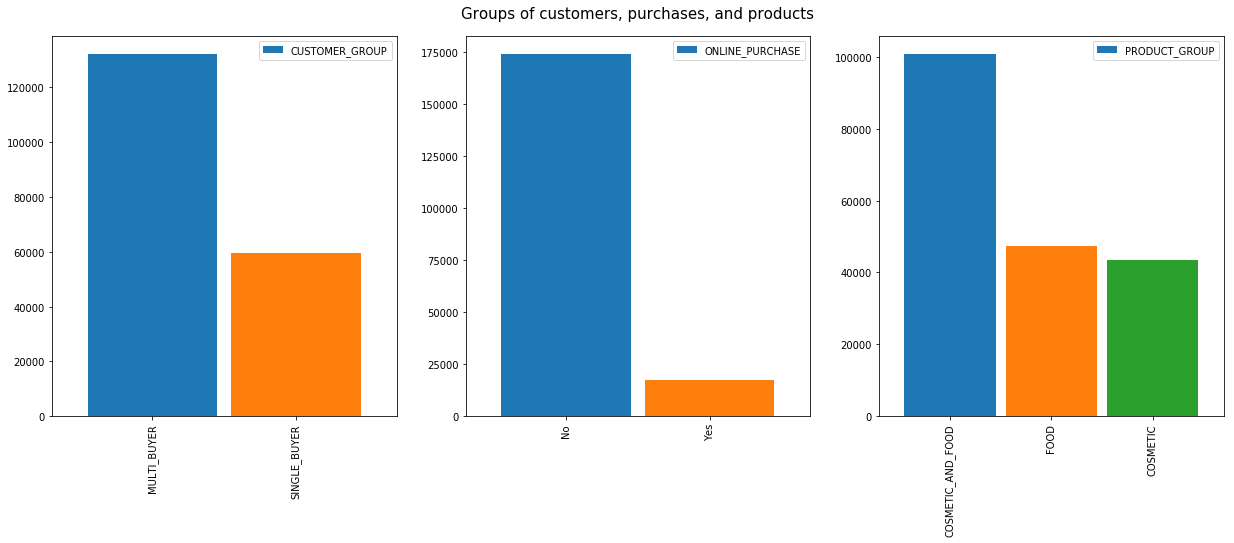

In [10]:
# Look at extra columns

extra = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers['ONLINE_PURCHASE'] = customers['ONLINE_PURCHASE'].astype(str)
customers['ONLINE_PURCHASE'].replace({'0': 'No', '1': 'Yes'}, inplace=True)

print(customers[extra].dtypes)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,7))
for i in range(3):
    customers[extra[i]].value_counts().plot(kind='bar', ax=ax[i], width=.9)
    ax[i].legend(loc='best')
ax[1].set_title('Groups of customers, purchases, and products', fontsize=15, y=1.03)
plt.show()

In [11]:
# Save this additional info in another customers_extra DF

extra = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers_extra = customers[extra]
customers.drop(extra, axis=1, inplace=True)

In [12]:
cat_cols_azdias = azdias.select_dtypes(include='object').columns
cat_cols_customers = customers.select_dtypes(include='object').columns
set(cat_cols_customers).difference(set(cat_cols_azdias))

set()

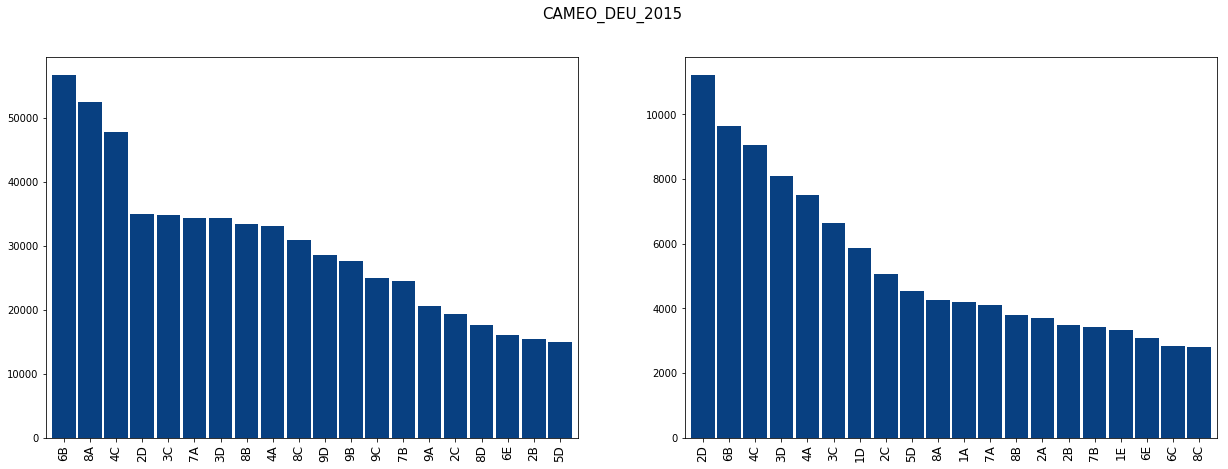

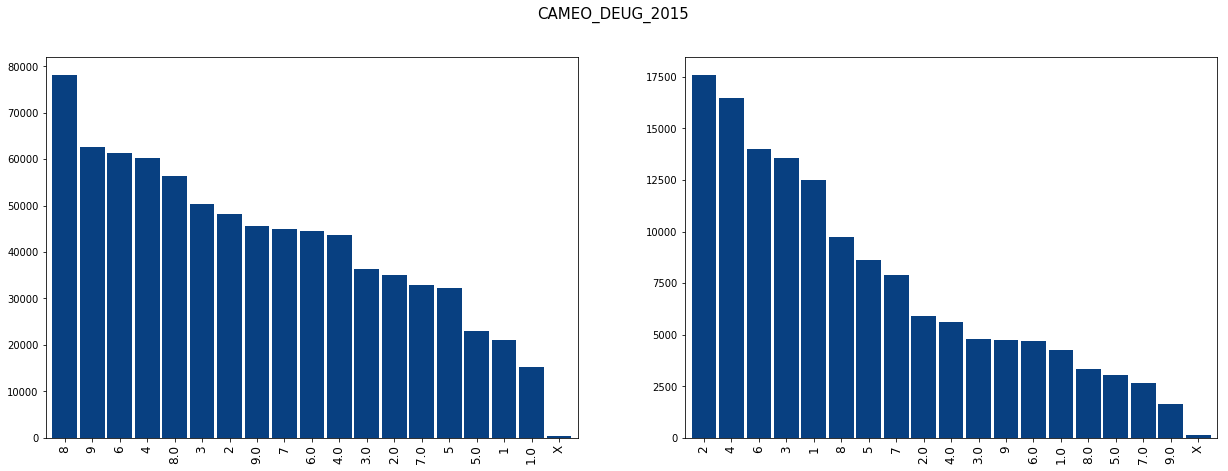

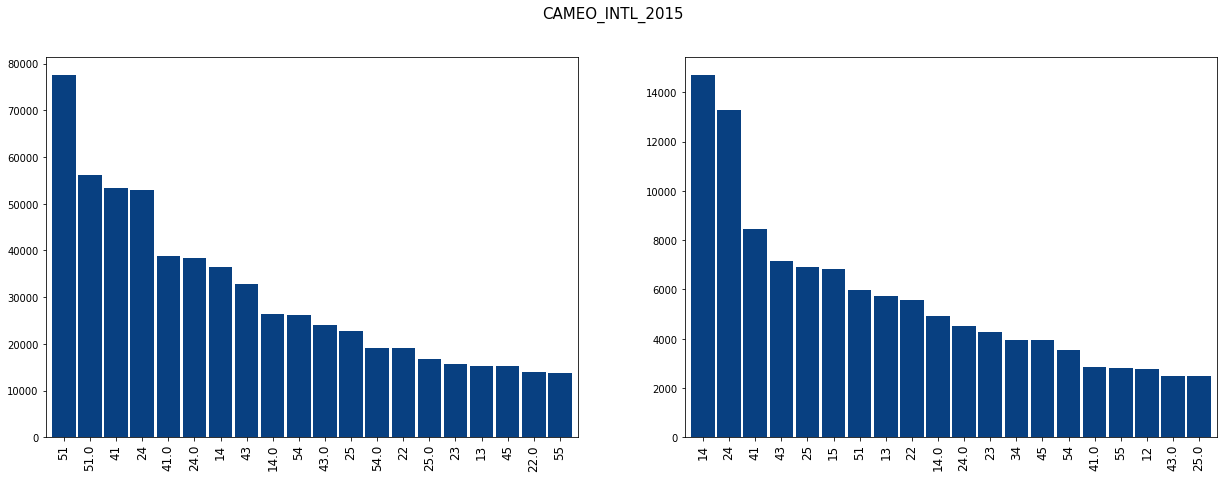

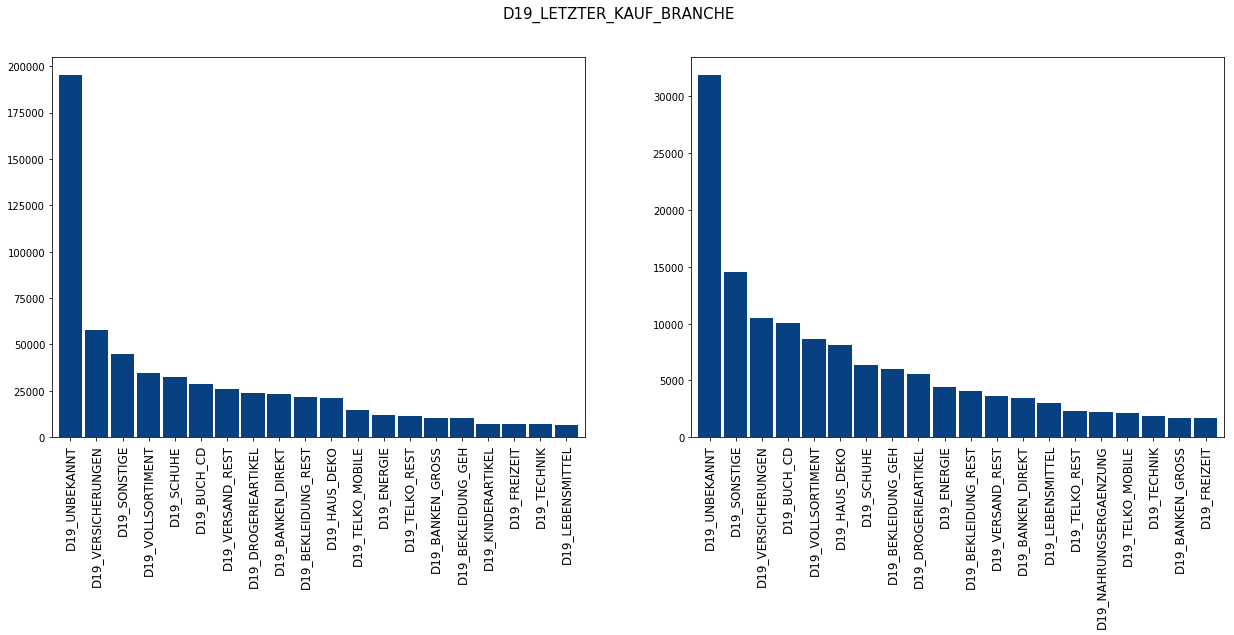

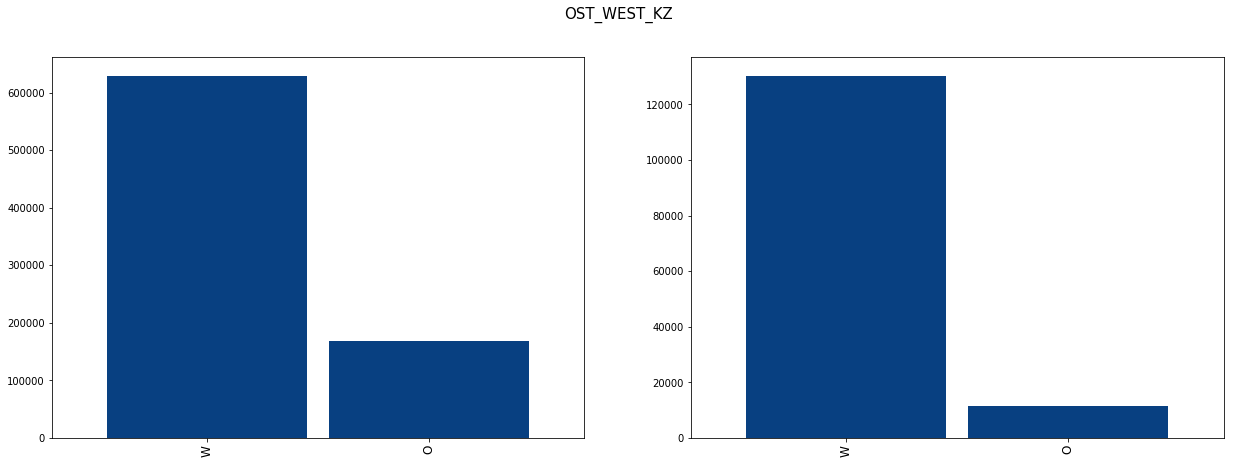

In [13]:
# Plot up to top-20

plt.rc('xtick', labelsize=12)

for column in cat_cols_azdias:
    if column != 'EINGEFUEGT_AM':
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21,7))
        azdias[column].value_counts().iloc[:20].plot(kind='bar', ax=ax[0], width=0.9, cmap='GnBu_r')
        customers[column].value_counts().iloc[:20].plot(kind='bar', ax=ax[1], width=0.9, cmap='GnBu_r')
        plt.suptitle(column, fontsize=15)
        plt.show()

In [14]:
print(azdias['EINGEFUEGT_AM'].dtype)
print(azdias['EINGEFUEGT_AM'].unique())
azdias['EINGEFUEGT_AM'].value_counts().describe()

object
[nan '1992-02-10 00:00:00' '1992-02-12 00:00:00' ..., '2010-12-02 00:00:00'
 '2005-03-19 00:00:00' '2011-11-18 00:00:00']


count      5162.000000
mean        154.605386
std        5977.496782
min           1.000000
25%           2.000000
50%           6.000000
75%          19.000000
max      383738.000000
Name: EINGEFUEGT_AM, dtype: float64

In [15]:
print(customers['EINGEFUEGT_AM'].dtype)
print(customers['EINGEFUEGT_AM'].unique())
customers['EINGEFUEGT_AM'].value_counts().describe()

object
['1992-02-12 00:00:00' nan '1992-02-10 00:00:00' ..., '2008-04-25 00:00:00'
 '2005-03-30 00:00:00' '2008-07-14 00:00:00']


count     3034.000000
mean        46.712261
std       1417.970544
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      64744.000000
Name: EINGEFUEGT_AM, dtype: float64

#### Work with DIAS Information Levels and Values / 2017

In [16]:
# load in a top-level list of attributes and descriptions, organized by informational category file

levels_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=1)
levels_df = levels_df[['Information level', 'Attribute', 'Description']]
levels_df.loc[0, 'Information level'] = 'Person'
levels_df.loc[88:96, 'Information level'] = 'Microcell (RR3_ID)'
levels_df['Information level'] = levels_df['Information level'].fillna(method='ffill')
levels_df.head()

,Information level,Attribute,Description
0,Person,AGER_TYP,best-ager typology
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis
2,Person,ANREDE_KZ,gender
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest


In [17]:
levels_df['Information level'].unique()

array(['Person', 'Household', 'Building', 'Microcell (RR4_ID)',
       'Microcell (RR3_ID)', '125m x 125m Grid', 'Postcode ', 'RR1_ID',
       'PLZ8', 'Community'], dtype=object)

In [18]:
# load in a detailed mapping of data values for each feature in alphabetical order

values_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1)
values_df.drop('Unnamed: 0', axis=1, inplace=True)
values_df = values_df.fillna(method='ffill')
values_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [19]:
details = values_df.merge(levels_df, on=['Attribute', 'Description'], how='left')
details.head()

,Attribute,Description,Value,Meaning,Information level
0,AGER_TYP,best-ager typology,-1,unknown,Person
1,AGER_TYP,best-ager typology,0,no classification possible,Person
2,AGER_TYP,best-ager typology,1,passive elderly,Person
3,AGER_TYP,best-ager typology,2,cultural elderly,Person
4,AGER_TYP,best-ager typology,3,experience-driven elderly,Person


In [20]:
details.isnull().sum()

Attribute              0
Description            0
Value                  0
Meaning                0
Information level    662
dtype: int64

In [21]:
details.head(10)

,Attribute,Description,Value,Meaning,Information level
0,AGER_TYP,best-ager typology,-1,unknown,Person
1,AGER_TYP,best-ager typology,0,no classification possible,Person
2,AGER_TYP,best-ager typology,1,passive elderly,Person
3,AGER_TYP,best-ager typology,2,cultural elderly,Person
4,AGER_TYP,best-ager typology,3,experience-driven elderly,Person
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,NaN
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years,NaN
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years,NaN
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years,NaN
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years,NaN


In [22]:
# Number of all values and unique Attributes in DIAS data
details.shape, details.Attribute.unique().shape

((2258, 5), (314,))

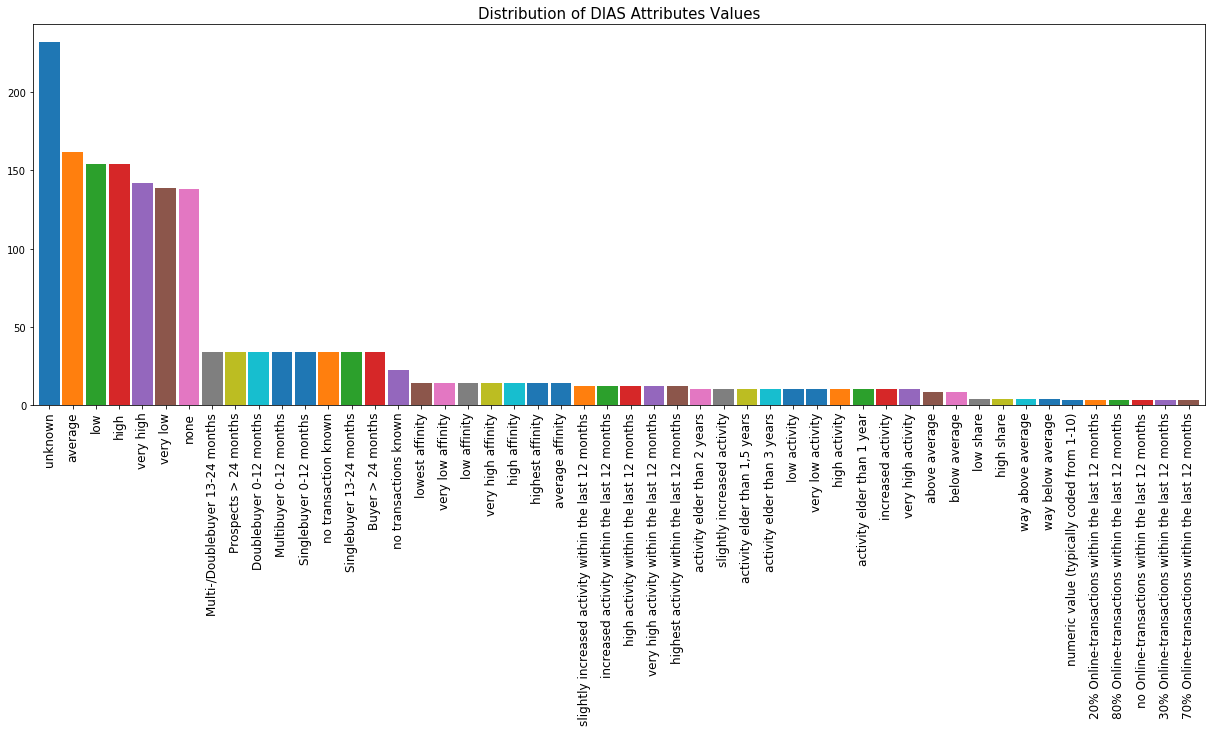

In [23]:
details.Meaning.value_counts().iloc[:50].plot.bar(figsize=(21,7), width=.9)
plt.title('Distribution of DIAS Attributes Values', fontsize=15)
plt.show()

In the following part such values as "unknown" or "unknown / no main age detectable", etc. will be replaced with NaNs.

#### Replace unknown values in azdias and customers with NaN using details DF

In [24]:
# Get list of Attribute - Value where "unknown" or "no transaction(s) known" is present in Meaning

details['meaning'] = details.Meaning.str.lower().astype(str)
unknown = details[(details.meaning.str.contains('unknown')) |
                  (details.meaning.isin(['no transactions known', 'no transaction known']))][['Attribute', 'Value']]
unknown.set_index('Attribute', inplace=True)
unknown.head()

,Value
Attribute,
AGER_TYP,-1
ALTERSKATEGORIE_GROB,"-1, 0"
ALTER_HH,0
ANREDE_KZ,"-1, 0"
BALLRAUM,-1


In [25]:
def replace_unknown_with_nan(df, unknown):

    cols_df = df.columns
    for column in unknown.index:
        if column in cols_df:
            col_values = df[column].unique().tolist()
            unknown_vals = unknown.loc[column]['Value']
            for val in col_values:
                if isinstance(unknown_vals, int):
                    if val == unknown_vals:
                        df[column] = df[column].replace(val, np.nan)
                else:
                    if str(val) in unknown_vals.split():
                        df[column] = df[column].replace(val, np.nan)
    return df

#### Apply function replace_unknown_with_nan to azdias dataframe

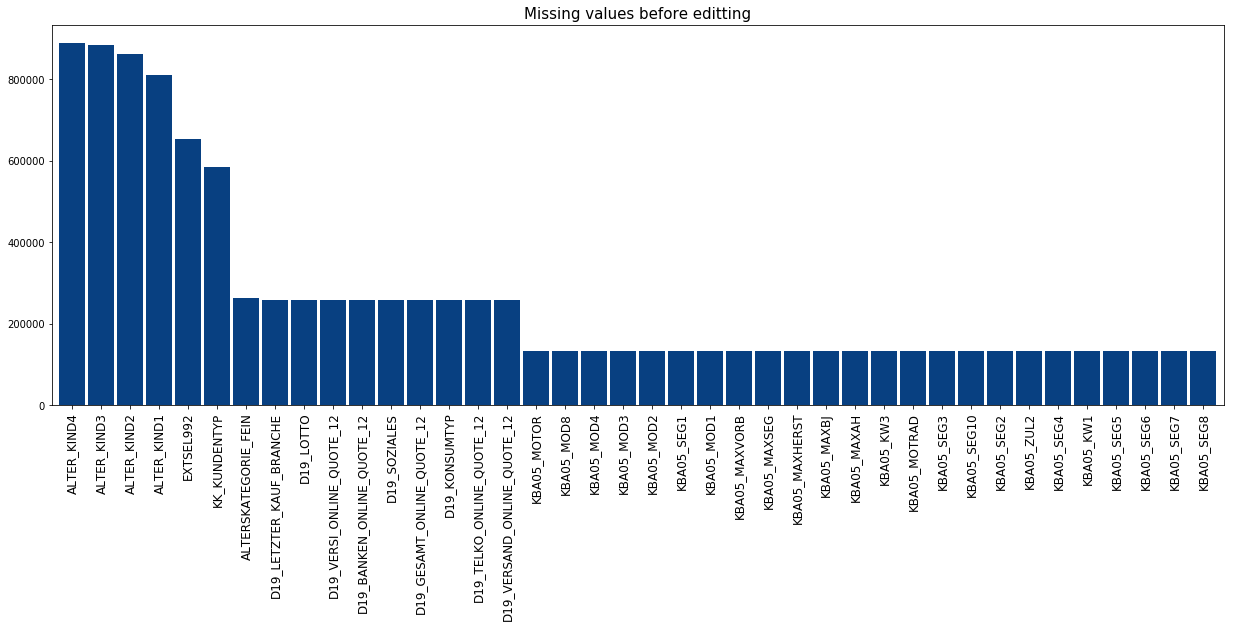

In [26]:
azdias.isnull().sum().sort_values(ascending=False).iloc[:40].plot.bar(figsize=(21,7), width=.9, cmap='GnBu_r')
plt.title('Missing values before editting', fontsize=15)
plt.show()

In [27]:
azdias = replace_unknown_with_nan(azdias, unknown)

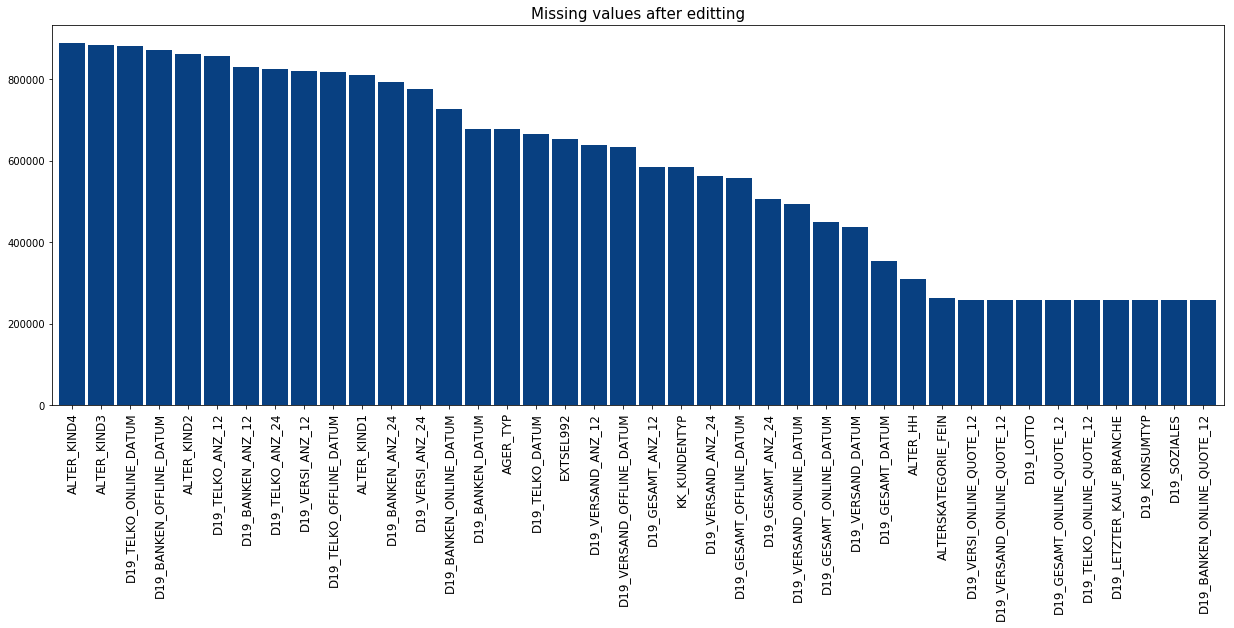

In [28]:
azdias.isnull().sum().sort_values(ascending=False).iloc[:40].plot.bar(figsize=(21,7), width=.9, cmap='GnBu_r')
plt.title('Missing values after editting', fontsize=15)
plt.show()

#### Apply function replace_unknown_with_nan to customers dataframe

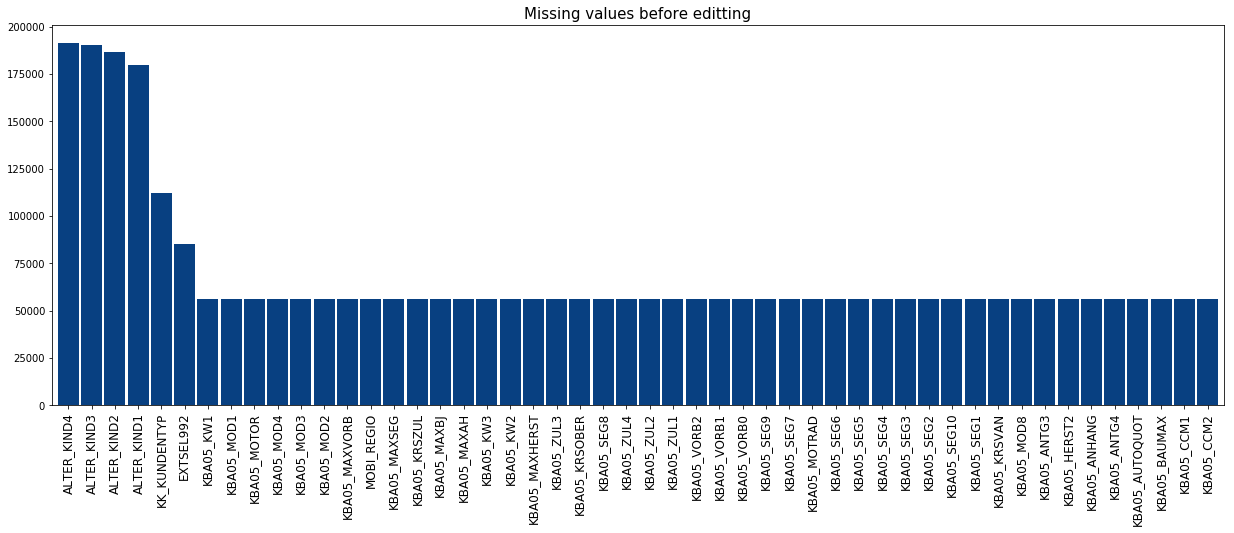

In [29]:
customers.isnull().sum().sort_values(ascending=False).iloc[:50].plot.bar(figsize=(21,7), width=.9, cmap='GnBu_r')
plt.title('Missing values before editting', fontsize=15)
plt.show()

In [30]:
customers = replace_unknown_with_nan(customers, unknown)

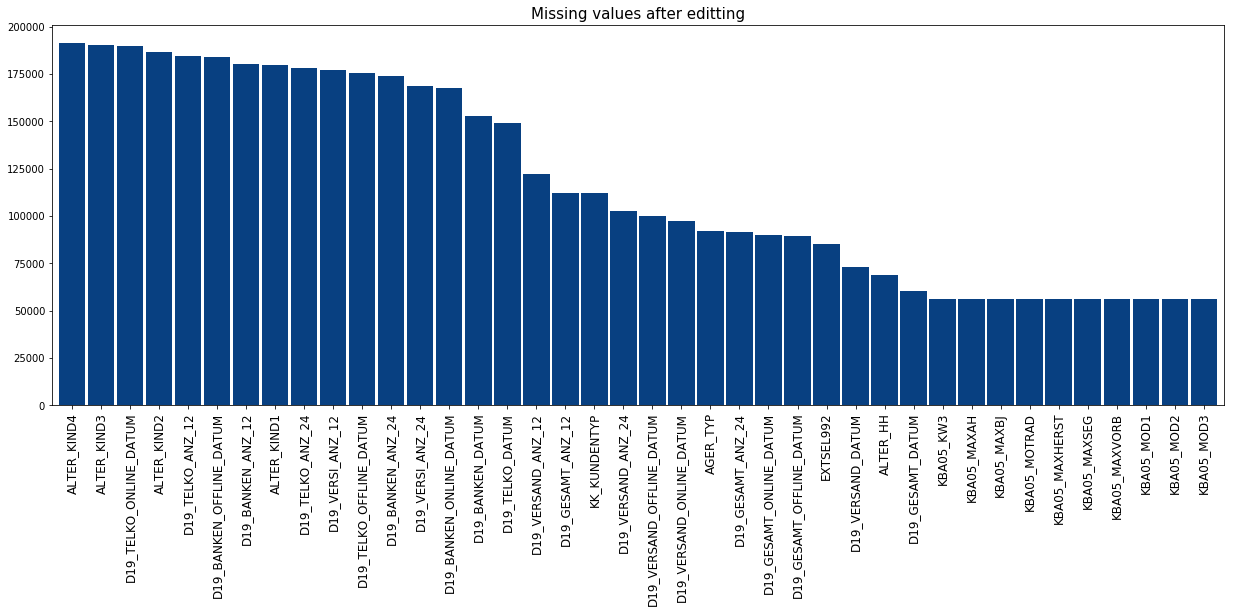

In [31]:
customers.isnull().sum().sort_values(ascending=False).iloc[:40].plot.bar(figsize=(21,7), width=.9, cmap='GnBu_r')
plt.title('Missing values after editting', fontsize=15)
plt.show()

#### Drop columns from azdias and customers where there's no corresponding value in Attribute in details DF

In [32]:
# Differences and similarities in azdias and details DF

common_cols = set(azdias.columns.tolist()).intersection(set(details.Attribute.unique().tolist()))
different_cols = set(azdias.columns.tolist()).symmetric_difference(set(details.Attribute.unique().tolist()))
different_azdias_cols = set(azdias.columns.tolist()).difference(set(details.Attribute.unique().tolist()))
different_details_cols = set(details.Attribute.tolist()).difference(set(azdias.columns.unique().tolist()))

print('Same for both azdias and details', len(common_cols))
print('Different for both azdias and details', len(different_cols))
print('Different for azdias', len(different_azdias_cols))
print('Different for details', len(different_details_cols))


Same for both azdias and details 272
Different for both azdias and details 136
Different for azdias 94
Different for details 42


In [33]:
# Differences and similarities in customers and details DF

common_cols = set(customers.columns.tolist()).intersection(set(details.Attribute.unique().tolist()))
different_cols = set(customers.columns.tolist()).symmetric_difference(set(details.Attribute.unique().tolist()))
different_customers_cols = set(customers.columns.tolist()).difference(set(details.Attribute.unique().tolist()))
different_details_cols = set(details.Attribute.tolist()).difference(set(customers.columns.unique().tolist()))

print('Same for both customers and details', len(common_cols))
print('Different for both customers and details', len(different_cols))
print('Different for customers', len(different_azdias_cols))
print('Different for details', len(different_details_cols))


Same for both customers and details 272
Different for both customers and details 136
Different for customers 94
Different for details 42


It seems that D19 columns with "RZ" in the end of column names in DIAS Attributes DF ("RZ" stands for "Herzogtum Lauenburg" region in Germany) means the same as the corresponding columns of total population. So, the unknown or missing values could also be replaced with NaN.
The same could be applied to columns CAMEO_INTL_2015 (azdias DF) and CAMEO_DEUINTL_2015 () are the same (and probably "DEU" means "Deutsche Eislauf-Union", but it's not exact).

In [34]:
details[details.Attribute == 'D19_BANKEN_GROSS_RZ'].head()

,Attribute,Description,Value,Meaning,Information level,meaning
170,D19_BANKEN_GROSS_RZ,transactional activity based on the product gr...,0,no transaction known,NaN,no transaction known
171,D19_BANKEN_GROSS_RZ,- on grid level -,1,Multibuyer 0-12 months,NaN,multibuyer 0-12 months
172,D19_BANKEN_GROSS_RZ,- on grid level -,2,Doublebuyer 0-12 months,NaN,doublebuyer 0-12 months
173,D19_BANKEN_GROSS_RZ,- on grid level -,3,Singlebuyer 0-12 months,NaN,singlebuyer 0-12 months
174,D19_BANKEN_GROSS_RZ,- on grid level -,4,Multi-/Doublebuyer 13-24 months,NaN,multi-/doublebuyer 13-24 months


In [35]:
details.Attribute = details.Attribute.str.replace('_RZ', '')
details[details.Attribute == 'D19_BANKEN_GROSS'].head()

,Attribute,Description,Value,Meaning,Information level,meaning
170,D19_BANKEN_GROSS,transactional activity based on the product gr...,0,no transaction known,NaN,no transaction known
171,D19_BANKEN_GROSS,- on grid level -,1,Multibuyer 0-12 months,NaN,multibuyer 0-12 months
172,D19_BANKEN_GROSS,- on grid level -,2,Doublebuyer 0-12 months,NaN,doublebuyer 0-12 months
173,D19_BANKEN_GROSS,- on grid level -,3,Singlebuyer 0-12 months,NaN,singlebuyer 0-12 months
174,D19_BANKEN_GROSS,- on grid level -,4,Multi-/Doublebuyer 13-24 months,NaN,multi-/doublebuyer 13-24 months


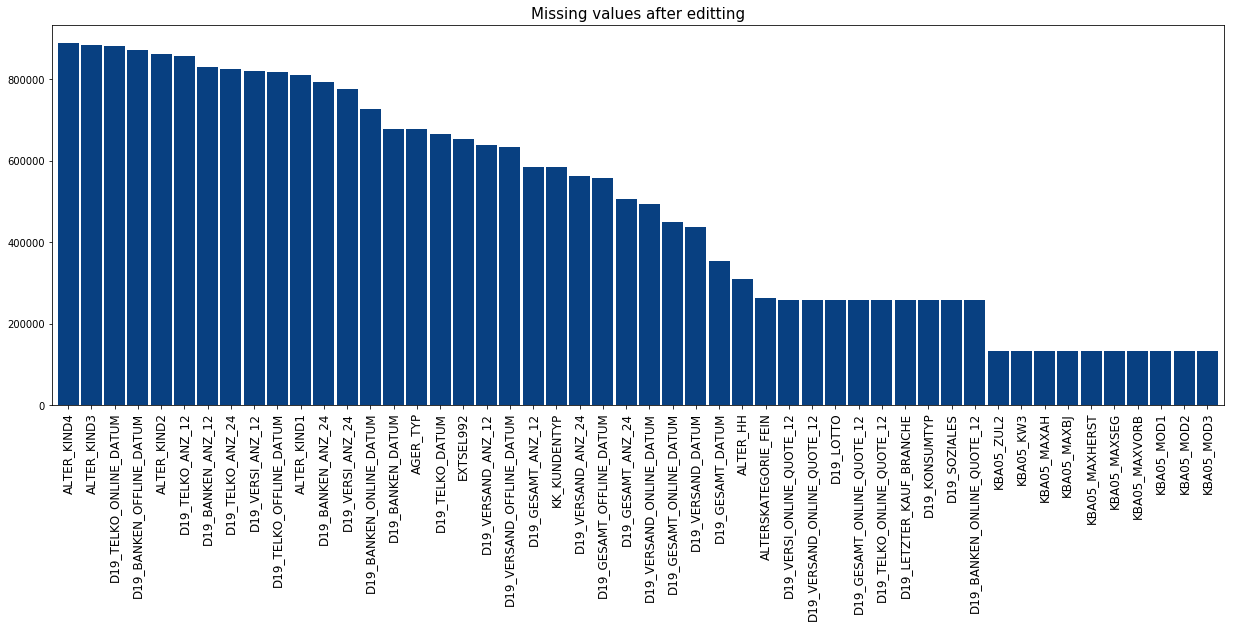

In [36]:
azdias = replace_unknown_with_nan(azdias, unknown)

azdias.isnull().sum().sort_values(ascending=False).iloc[:50].plot.bar(figsize=(21,7), width=.9, cmap='GnBu_r')
plt.title('Missing values after editting', fontsize=15)
plt.show()

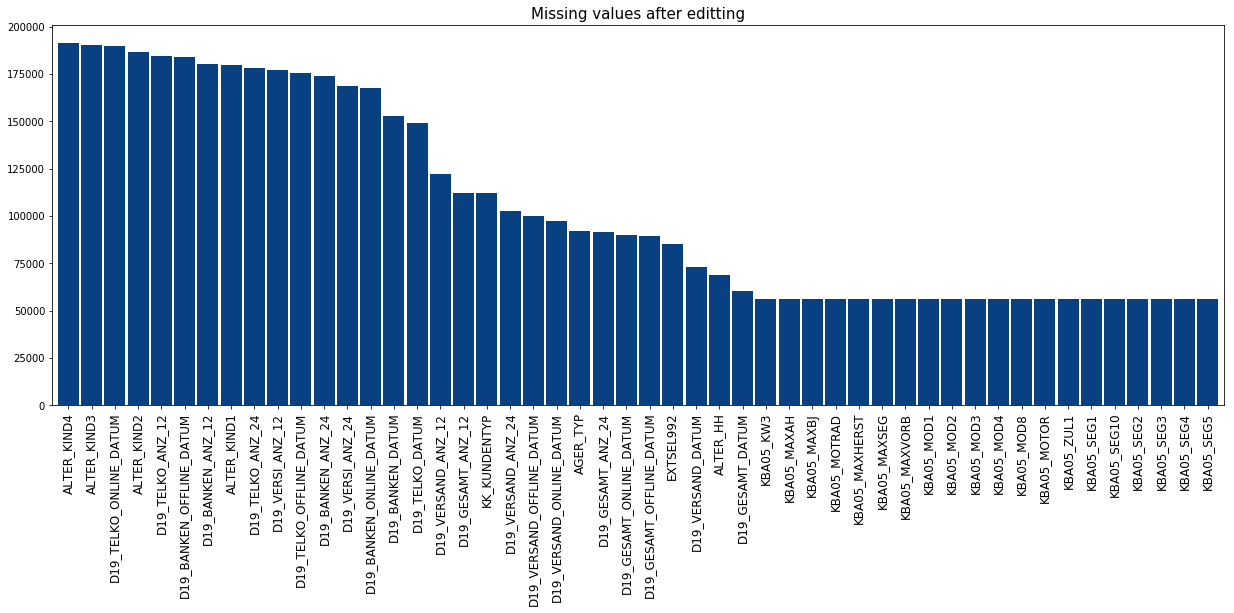

In [37]:
customers = replace_unknown_with_nan(customers, unknown)

customers.isnull().sum().sort_values(ascending=False).iloc[:50].plot.bar(figsize=(21,7), width=.9, cmap='GnBu_r')
plt.title('Missing values after editting', fontsize=15)
plt.show()

#### Convert categorical columns to numeric where possible

In [38]:
def object_toNumeric(df):

    cat_cols = df.select_dtypes(include='object').columns
    for column in cat_cols:
        print(column)
        unqiue_vals = df[column].unique()
        print('Unique values in', column, unqiue_vals, '\n')
        if ('X' in unqiue_vals) or ('XX' in unqiue_vals):
            df[column] = df[column].replace({'X': np.nan, 'XX': np.nan})
            df[column] = pd.to_numeric(df[column], errors='coerse')

    return df

In [39]:
azdias = object_toNumeric(azdias)
azdias.select_dtypes(include='object').head()

CAMEO_DEU_2015
Unique values in CAMEO_DEU_2015 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX'] 

CAMEO_DEUG_2015
Unique values in CAMEO_DEUG_2015 [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X'] 

CAMEO_INTL_2015
Unique values in CAMEO_INTL_2015 [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX'] 

D19_LETZTER_KAUF_BRANCHE
Unique values in D19_LETZTER_KAUF_BRANCHE [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DI

,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN
1,NaN,1992-02-10 00:00:00,W
2,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,D19_SCHUHE,1992-02-12 00:00:00,W


In [40]:
customers = object_toNumeric(customers)
customers.select_dtypes(include='object').head()

CAMEO_DEU_2015
Unique values in CAMEO_DEU_2015 ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C' '5A'
 '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D' '6F' '4D'
 'XX'] 

CAMEO_DEUG_2015
Unique values in CAMEO_DEUG_2015 [1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X'] 

CAMEO_INTL_2015
Unique values in CAMEO_INTL_2015 [13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43' '22'
 '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33' 'XX'] 

D19_LETZTER_KAUF_BRANCHE
Unique values in D19_LETZTER_KAUF_BRANCHE ['D19_UNBEKANNT' 'D19_BANKEN_GROSS' 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE'
 'D19_BUCH_CD' 'D19_DROGERIEARTIKEL' 'D19_SONSTIGE' 'D19_TECHNIK'
 'D19_VERSICHERUNGEN' 'D19_TELKO_MOBILE' 'D19_VOLLSORTIMENT' nan
 'D19_HAUS_DEKO' 'D19_ENERGIE' 'D19_R

,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,D19_UNBEKANNT,1992-02-12 00:00:00,W
1,D19_BANKEN_GROSS,NaN,NaN
2,D19_UNBEKANNT,1992-02-10 00:00:00,W
3,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W
4,D19_SCHUHE,1992-02-12 00:00:00,W


#### Convert categorical columns to datetime where possible

In [41]:
def object_toDatetime(df, column):

    df[column] = pd.to_datetime(df[column])
    df['YEAR'] = df[column].dt.year
    df['MONTH'] = df[column].dt.month
    df.drop(column, axis=1, inplace=True)

    return df

In [42]:
azdias = object_toDatetime(azdias, 'EINGEFUEGT_AM')
azdias[['YEAR', 'MONTH']].head()

,YEAR,MONTH
0,NaN,NaN
1,1992.0,2.0
2,1992.0,2.0
3,1997.0,4.0
4,1992.0,2.0


In [43]:
customers = object_toDatetime(customers, 'EINGEFUEGT_AM')
customers[['YEAR', 'MONTH']].head()

,YEAR,MONTH
0,1992.0,2.0
1,NaN,NaN
2,1992.0,2.0
3,1992.0,2.0
4,1992.0,2.0


#### Missing values

In [44]:
nan_azdias = azdias.isnull().sum()
nan_azdias = nan_azdias.sort_values(ascending=False)
nan_azdias_cols = nan_azdias[nan_azdias > 0]
print('Number of columns with NaNs is', len(nan_azdias_cols))
proportion_azdias = nan_azdias_cols / azdias.shape[0]
print(proportion_azdias[proportion_azdias > .9])

Number of columns with NaNs is 302
CAMEO_DEU_2015              1.000000
ALTER_KIND4                 0.998648
ALTER_KIND3                 0.993077
D19_TELKO_ONLINE_DATUM      0.990796
D19_BANKEN_OFFLINE_DATUM    0.977911
ALTER_KIND2                 0.966900
D19_TELKO_ANZ_12            0.962713
D19_BANKEN_ANZ_12           0.933252
D19_TELKO_ANZ_24            0.927052
D19_VERSI_ANZ_12            0.921532
D19_TELKO_OFFLINE_DATUM     0.919092
ALTER_KIND1                 0.909048
dtype: float64


In [45]:
nan_customers = customers.isnull().sum()
nan_customers = nan_customers.sort_values(ascending=False)
nan_customers_cols = nan_customers[nan_customers > 0]
print('Number of columns with NaNs is', len(nan_customers_cols))
proportion_customers = nan_customers_cols / customers.shape[0]
print(proportion_customers[proportion_customers > .9])

Number of columns with NaNs is 302
CAMEO_DEU_2015              1.000000
ALTER_KIND4                 0.998769
ALTER_KIND3                 0.993347
D19_TELKO_ONLINE_DATUM      0.988855
ALTER_KIND2                 0.973389
D19_TELKO_ANZ_12            0.962510
D19_BANKEN_OFFLINE_DATUM    0.961127
D19_BANKEN_ANZ_12           0.939985
ALTER_KIND1                 0.938607
D19_TELKO_ANZ_24            0.930911
D19_VERSI_ANZ_12            0.924780
D19_TELKO_OFFLINE_DATUM     0.916635
D19_BANKEN_ANZ_24           0.906335
dtype: float64


In [46]:
# Delete columns with more than 90% missing values

cols_to_drop = nan_azdias_cols[nan_azdias_cols / azdias.shape[0] > .9].index.tolist()
azdias.drop(cols_to_drop, axis=1, inplace=True)

In [47]:
cols_to_drop = nan_customers_cols[nan_customers_cols / customers.shape[0] > .9].index.tolist()
customers.drop(cols_to_drop, axis=1, inplace=True)

In [48]:
# Column which has a little bit less missing values in azdias than in customers DF

difference = (set(proportion_customers[proportion_customers > .9].index)
                  .difference(set(proportion_azdias[proportion_azdias > .9].index)))
print(difference)
print(proportion_azdias[difference])

azdias.drop(difference, axis=1, inplace=True)

{'D19_BANKEN_ANZ_24'}
D19_BANKEN_ANZ_24    0.891025
dtype: float64


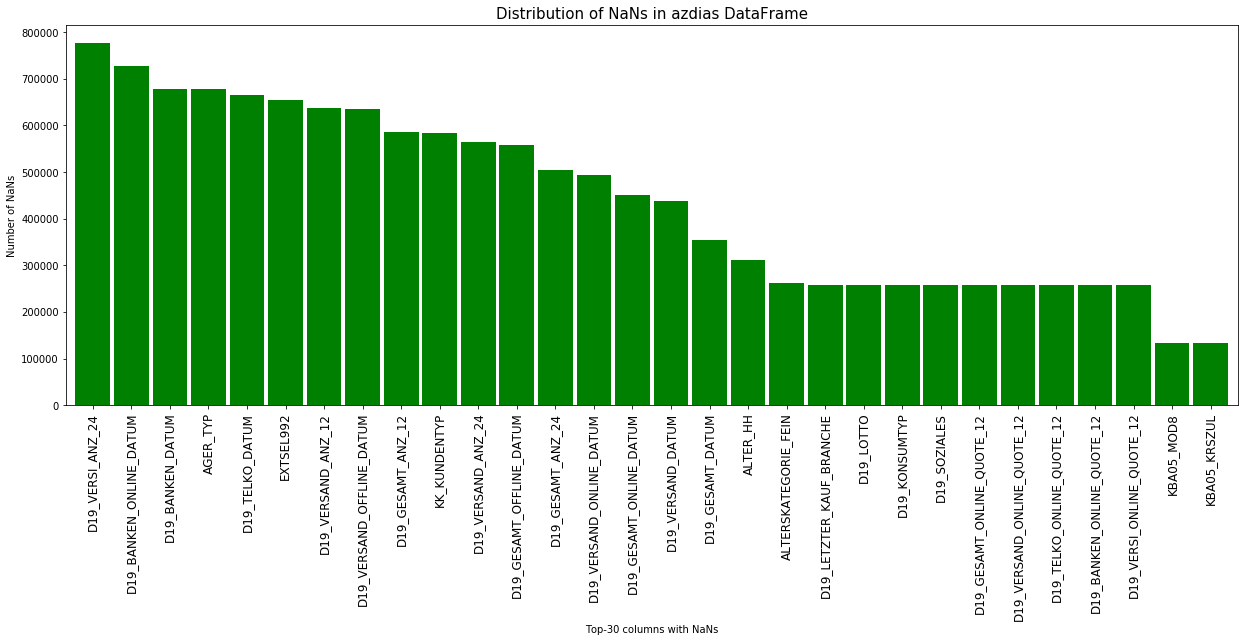

In [49]:
# Visualize distribution of missing values in top-30 columns in azdias

nan_azdias = azdias.isnull().sum()
nan_azdias = nan_azdias.sort_values(ascending=False)
nan_azdias_cols = nan_azdias[nan_azdias > 0]

nan_azdias_cols.iloc[:30].plot(kind='bar', figsize=(21,7), width=.9, color='green')
plt.xticks(rotation=90)
plt.title('Distribution of NaNs in azdias DataFrame', fontsize=15)
plt.xlabel('Top-30 columns with NaNs')
plt.ylabel('Number of NaNs')

plt.show()

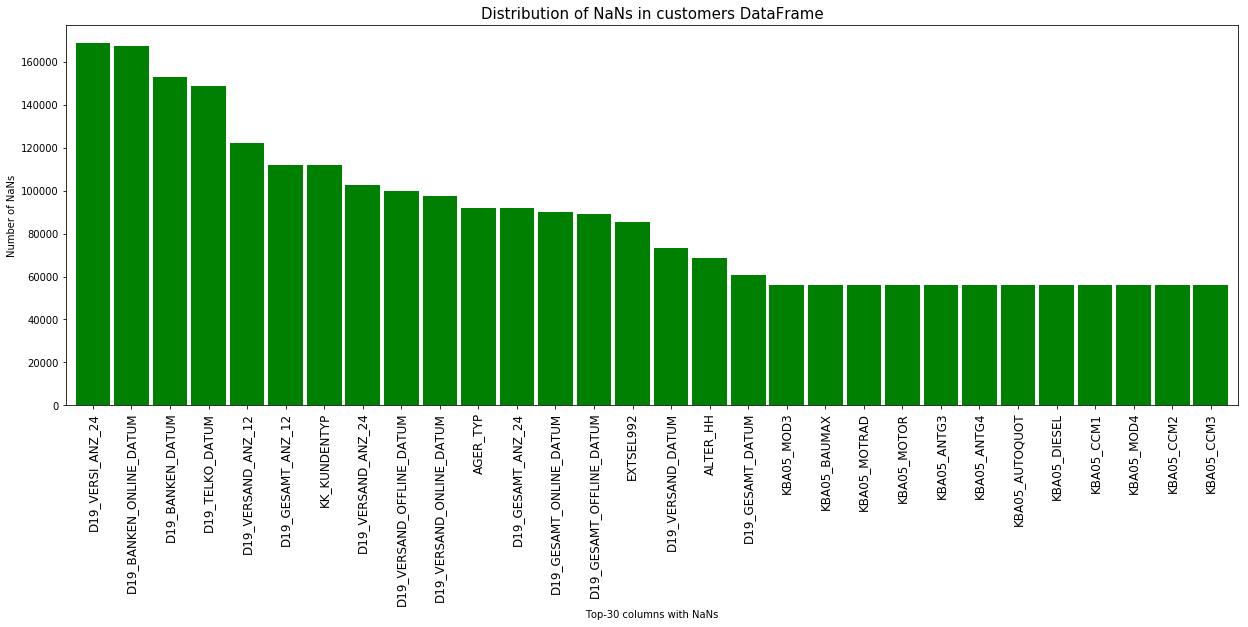

In [50]:
# Visualize distribution of missing values in top-30 columns in customers

nan_customers = customers.isnull().sum()
nan_customers = nan_customers.sort_values(ascending=False)
nan_customers_cols = nan_customers[nan_customers > 0]

nan_customers_cols.iloc[:30].plot(kind='bar', figsize=(21,7), width=.9, color='green')
plt.xticks(rotation=90)
plt.title('Distribution of NaNs in customers DataFrame', fontsize=15)
plt.xlabel('Top-30 columns with NaNs')
plt.ylabel('Number of NaNs')

plt.show()

In [51]:
print('Shape after deleting columns with more than 90% missing values')
print('Azdias', azdias.shape)
print('Customers', customers.shape)

Shape after deleting columns with more than 90% missing values
Azdias (891221, 354)
Customers (191652, 354)


#### Drop columns and create new ones

In [52]:
# Create column which represent sum of NaN in each row

def create_num_missing_column(df):    
    df['Num_missing'] = df.isnull().sum(axis=1)
    
    return df

In [53]:
azdias = create_num_missing_column(azdias)

In [54]:
customers = create_num_missing_column(customers)

In [55]:
# For columns with NaN more than 10% and less 90% replace missing values with 0s, and non-missing with 1s

def tranform_cols_with_missing(df):
    nan_df = df.isnull().sum() / df.shape[0]
    nan_cols = nan_df[(nan_df > .1) & (nan_df < .9)]
    for column in nan_cols.index:
        print(column)
        df[column] = np.where(df[column].isnull(), 0, 1)
    
    return df

In [56]:
azdias = tranform_cols_with_missing(azdias)

AGER_TYP
ALTER_HH
ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_STATISTISCHE_HAUSHALTE
ARBEIT
BALLRAUM
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_BANKEN_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_KONSUMTYP
D19_LETZTER_KAUF_BRANCHE
D19_LOTTO
D19_SOZIALES
D19_TELKO_DATUM
D19_TELKO_ONLINE_QUOTE_12
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ANZ_24
D19_VERSI_ONLINE_QUOTE_12
DSL_FLAG
EWDICHTE
EXTSEL992
FIRMENDICHTE
GEBAEUDETYP
GEBAEUDETYP_RASTER
GEMEINDETYP
HEALTH_TYP
HH_DELTA_FLAG
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA05_GBZ
KBA05_HERST1
KBA05_HERST2
KBA05_HER

In [57]:
customers = tranform_cols_with_missing(customers)

AGER_TYP
AKT_DAT_KL
ALTER_HH
ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_STATISTISCHE_HAUSHALTE
ANZ_TITEL
ARBEIT
BALLRAUM
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_BANKEN_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_KONSUMTYP
D19_LETZTER_KAUF_BRANCHE
D19_LOTTO
D19_SOZIALES
D19_TELKO_DATUM
D19_TELKO_ONLINE_QUOTE_12
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ANZ_24
D19_VERSI_ONLINE_QUOTE_12
DSL_FLAG
EINGEZOGENAM_HH_JAHR
EWDICHTE
EXTSEL992
FIRMENDICHTE
GEBAEUDETYP
GEBAEUDETYP_RASTER
GEMEINDETYP
HEALTH_TYP
HH_DELTA_FLAG
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA

In [58]:
print('# of missing in azdias', azdias.isnull().sum().sum())
print('# of missing in customers', customers.isnull().sum().sum())

# of missing in azdias 1198510
# of missing in customers 64015


In [59]:
# Work with azdias DF where # of missing values < 10%

nan_azdias = azdias.isnull().sum() / azdias.shape[0]
nan_cols = nan_azdias[(nan_azdias > 0) & (nan_azdias < .1)]
print(nan_cols)

AKT_DAT_KL              0.082470
ANZ_KINDER              0.082470
ANZ_PERSONEN            0.082470
ANZ_TITEL               0.082470
CJT_GESAMTTYP           0.005446
CJT_KATALOGNUTZER       0.005446
CJT_TYP_1               0.005446
CJT_TYP_2               0.005446
CJT_TYP_3               0.005446
CJT_TYP_4               0.005446
CJT_TYP_5               0.005446
CJT_TYP_6               0.005446
EINGEZOGENAM_HH_JAHR    0.082470
GFK_URLAUBERTYP         0.005446
HH_EINKOMMEN_SCORE      0.020587
KONSUMNAEHE             0.082997
LP_FAMILIE_FEIN         0.005446
LP_FAMILIE_GROB         0.005446
LP_LEBENSPHASE_FEIN     0.005446
LP_LEBENSPHASE_GROB     0.005446
LP_STATUS_FEIN          0.005446
LP_STATUS_GROB          0.005446
ONLINE_AFFINITAET       0.005446
RETOURTYP_BK_S          0.005446
RT_KEIN_ANREIZ          0.005446
RT_SCHNAEPPCHEN         0.005446
RT_UEBERGROESSE         0.057478
SOHO_KZ                 0.082470
TITEL_KZ                0.082470
UNGLEICHENN_FLAG        0.082470
VHA       

Replace missing values with modes of correspondng columns.

In [60]:
for column in azdias[nan_cols.index]:
    col_mode = azdias[column].mode().values[0]
    azdias[column] = azdias[column].replace(np.nan, col_mode)

azdias.isnull().sum().sum()

0

In [61]:
# Work with customers DF where # of missing values < 10%

nan_customers = customers.isnull().sum() / customers.shape[0]
nan_cols = nan_customers[(nan_customers > 0) & (nan_customers < .1)]
print(nan_cols)

CJT_GESAMTTYP          0.016765
CJT_KATALOGNUTZER      0.016765
CJT_TYP_1              0.016765
CJT_TYP_2              0.016765
CJT_TYP_3              0.016765
CJT_TYP_4              0.016765
CJT_TYP_5              0.016765
CJT_TYP_6              0.016765
GFK_URLAUBERTYP        0.016765
HH_EINKOMMEN_SCORE     0.015486
LP_FAMILIE_FEIN        0.016765
LP_FAMILIE_GROB        0.016765
LP_LEBENSPHASE_FEIN    0.016765
LP_LEBENSPHASE_GROB    0.016765
LP_STATUS_FEIN         0.016765
LP_STATUS_GROB         0.016765
ONLINE_AFFINITAET      0.016765
RETOURTYP_BK_S         0.016765
RT_KEIN_ANREIZ         0.016765
RT_SCHNAEPPCHEN        0.016765
dtype: float64


In [62]:
# Check dtypes of columns with missing values

for column in customers[nan_cols.index]:
    print(column)
    print(customers[column].value_counts())

CJT_GESAMTTYP
6.0    51907
2.0    42841
4.0    26912
3.0    24343
1.0    24229
5.0    18207
Name: CJT_GESAMTTYP, dtype: int64
CJT_KATALOGNUTZER
5.0    107544
4.0     27271
3.0     22087
1.0     20510
2.0     11027
Name: CJT_KATALOGNUTZER, dtype: int64
CJT_TYP_1
1.0    55916
2.0    53362
5.0    46069
3.0    23080
4.0    10012
Name: CJT_TYP_1, dtype: int64
CJT_TYP_2
1.0    64716
2.0    51794
5.0    44294
3.0    20079
4.0     7556
Name: CJT_TYP_2, dtype: int64
CJT_TYP_3
5.0    133124
4.0     30494
3.0     15564
2.0      7515
1.0      1742
Name: CJT_TYP_3, dtype: int64
CJT_TYP_4
5.0    127878
4.0     32339
3.0     11982
2.0     11086
1.0      5154
Name: CJT_TYP_4, dtype: int64
CJT_TYP_5
5.0    136309
4.0     24855
3.0     18855
2.0      5786
1.0      2634
Name: CJT_TYP_5, dtype: int64
CJT_TYP_6
5.0    137643
4.0     27282
3.0     12791
2.0      8855
1.0      1868
Name: CJT_TYP_6, dtype: int64
GFK_URLAUBERTYP
5.0     58113
10.0    27291
8.0     17631
4.0     16361
3.0     14684
7.0     1382

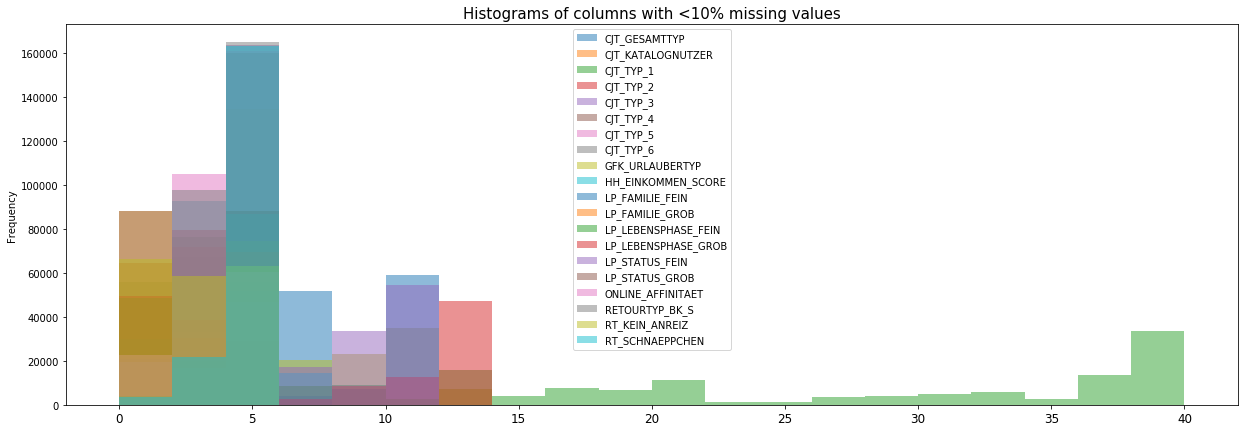

In [63]:
customers[nan_cols.index].plot.hist(figsize=(21,7), alpha=.5, bins=20)
plt.legend(loc='best')
plt.title('Histograms of columns with <10% missing values', fontsize=15)
plt.show()

In this case less than 2% of answers are missing. Since, values in this columns are discrete, and distributions are more or less normal (except "CJT_TYP_1" column), missing values will be replaced with modes of correspondng columns.

In [64]:
for column in customers[nan_cols.index]:
    col_mode = customers[column].mode().values[0]
    customers[column] = customers[column].replace(np.nan, col_mode)

customers.isnull().sum().sum()

0

In [65]:
print('Whether all values in LNR column are unique in azdias DF -', len(azdias.LNR.unique()) == azdias.shape[0])
print('Whether all values in LNR column are unique in customers DF - ',
      len(customers.LNR.unique()) == customers.shape[0])

print('# of common values in LNR column', len(set(customers.LNR).intersection(set(azdias.LNR))))
print('# of different values in LNR column', len(set(customers.LNR).difference(set(azdias.LNR))))

# So, we can drop LNR column in both datasets
azdias.drop('LNR', axis=1, inplace=True)
customers.drop('LNR', axis=1, inplace=True)

Whether all values in LNR column are unique in azdias DF - True
Whether all values in LNR column are unique in customers DF -  True
# of common values in LNR column 0
# of different values in LNR column 191652


#### Create dummies from categorical variables

In [66]:
def create_dummies(df):

    cat_cols = df.select_dtypes(include='object').columns
    for column in cat_cols:
        num_unique = len(df[column].value_counts())
        if (num_unique == 2) or (num_unique == 3 and np.nan in df[column].value_counts()):
            values = df[column].value_counts()
            df[column] = df[column].replace({values.index[0]: 0, values.index[1]: 1})
        else:
            df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], drop_first=True)], axis=1)

    return df

In [67]:
azdias = create_dummies(azdias)
azdias.dtypes.value_counts()

int64      319
float64     35
dtype: int64

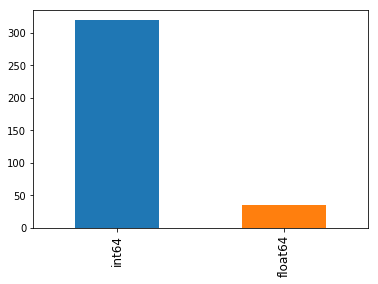

In [68]:
azdias.dtypes.value_counts().plot.bar()
plt.show()

In [69]:
customers = create_dummies(customers)
customers.dtypes.value_counts()

int64      334
float64     20
dtype: int64

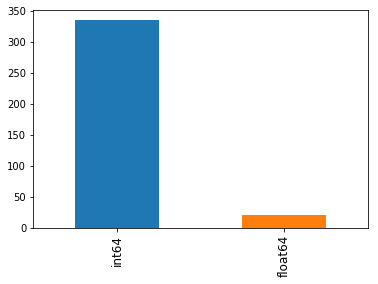

In [70]:
customers.dtypes.value_counts().plot.bar()
plt.show()

In [71]:
azdias.shape, customers.shape, customers_extra.shape

((891221, 354), (191652, 354), (191652, 3))

Function with pre-processing steps to clean all of the datasets before work with them.

In [133]:
def clean_demographic_data(df, unknown, cat_column='EINGEFUEGT_AM'):
    
    ##############################
    # Replace unknown values with NaNs

    cols_df = df.columns
    for column in unknown.index:
        if column in cols_df:
            col_values = df[column].unique().tolist()
            unknown_vals = unknown.loc[column]['Value']
            for val in col_values:
                if isinstance(unknown_vals, int):
                    if val == unknown_vals:
                        df[column] = df[column].replace(val, np.nan)
                else:
                    if str(val) in unknown_vals.split():
                        df[column] = df[column].replace(val, np.nan)

    
    ##############################
    # Convert categorical columns to numeric where possible
    
    cat_cols = df.select_dtypes(include='object').columns
    for column in cat_cols:
        unqiue_vals = df[column].unique()
        if ('X' in unqiue_vals) or ('XX' in unqiue_vals):
            df[column] = df[column].replace({'X': np.nan, 'XX': np.nan})
            df[column] = pd.to_numeric(df[column], errors='coerse')
    
    ##############################
    # Convert categorical columns to datetime where possible

    df[cat_column] = pd.to_datetime(df[cat_column])
    df['YEAR'] = df[cat_column].dt.year
    df['MONTH'] = df[cat_column].dt.month
    df.drop(cat_column, axis=1, inplace=True)
    
    ##############################
    # Missing values
    
    nan_df = df.isnull().sum()
    nan_df = nan_df.sort_values(ascending=False)
    nan_df_cols = nan_df[nan_df > 0]
    proportion_df = nan_df_cols / df.shape[0]
    
    # Delete columns with more than 90% missing values
    cols_to_drop = nan_df_cols[nan_df_cols / df.shape[0] > .9].index.tolist()
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    ##############################
    # Create column which represent sum of NaN in each row
    df['Num_missing'] = df.isnull().sum(axis=1)
    
    ##############################
    # Create column which represent sum of NaN in each row
    
    nan_df = df.isnull().sum() / df.shape[0]
    nan_cols = nan_df[(nan_df > .1) & (nan_df < .9)]
    for column in nan_cols.index:
        df[column] = np.where(df[column].isnull(), 0, 1)
    
    ##############################
    # LNR column    
    print('Whether all values in LNR column are unique in azdias DF -', len(df.LNR.unique()) == df.shape[0])
    df.drop('LNR', axis=1, inplace=True)
    
    ##############################
    # Work with customers DF where # of missing values < 10%

    nan_df = df.isnull().sum() / df.shape[0]
    nan_cols = nan_df[(nan_df > 0) & (nan_df < .1)]
    
    for column in df[nan_cols.index]:
        col_mode = df[column].mode().values[0]
        df[column] = df[column].replace(np.nan, col_mode)
    
    ##############################
    # Create dummies from categorical variables

    cat_cols = df.select_dtypes(include='object').columns
    for column in cat_cols:
        num_unique = len(df[column].value_counts())
        if (num_unique == 2) or (num_unique == 3 and np.nan in df[column].value_counts()):
            values = df[column].value_counts()
            df[column] = df[column].replace({values.index[0]: 0, values.index[1]: 1})
        else:
            df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], drop_first=True)], axis=1)
    

    
    print('Final check of missing values', df.isnull().sum().sum())
    
    return df


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Standardize values

In [73]:
azdias_cols = azdias.columns
customers_cols = customers.columns

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias)
print('azdias done!')
customers_scaled = scaler.transform(customers)

azdias done!


In [74]:
pd.DataFrame(azdias_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353
0,-0.561649,-0.869634,-1.368369,-1.545754,-2.927080,-2.861309,-0.292527,-0.593390,-2.927080,-0.057885,-2.857872,-2.916740,-2.823179,-2.823179,-1.027618,1.107775,-1.735176,-1.570560,1.172932,1.203659,1.181001,1.147432,-0.560218,-0.443741,-0.345901,-0.132111,-0.475309,-1.570434,-0.281739,-0.303388,-0.505301,-0.296161,-0.205967,-0.622234,-0.18977,-0.384133,-0.259375,-0.343098,-0.211033,-0.723867,-0.87392,-1.231408,-0.771735,-0.987989,-1.570434,-0.397223,-0.474667,-0.419129,-1.570434,0.976753,-0.438860,-0.242783,-1.570434,-1.570434,-0.20641,-0.31099,-0.450181,-0.330651,-0.356395,-0.826803,-1.570434,-0.634416,-0.581873,-0.461770,-1.570434,-0.395993,-0.207701,-0.630047,-0.762030,-1.017488,-0.636549,-0.895767,-1.570434,-0.433752,-0.383338,0.448642,0.153882,0.074836,-1.570434,-0.558923,-0.663482,-0.252831,-2.927080,-1.227660,-2.916740,-0.602000,1.285741,-0.055511,-0.056416,0.804890,1.429871,-0.303378,0.105346,-2.926957,-2.927080,-2.926957,-1.127583,-2.856915,0.742875,-0.494701,-2.648559,-2.698624,-1.379075,-2.916740,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.927080,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.927080,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.384245,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636,-2.724636

#### Implement PCA

In [75]:
pca = PCA(.9)
azdias_reduced = pca.fit_transform(azdias_scaled)
print('azdias done!')
customers_reduced = pca.transform(customers_scaled)
print('Explained variance ratio of azdias DF', pca.explained_variance_ratio_)

azdias done!
Explained variance ratio of azdias DF [ 0.5889759   0.06774619  0.04287888  0.03731728  0.01829001  0.01582645
  0.01184706  0.00967404  0.00810277  0.00746895  0.00675233  0.00632234
  0.00495845  0.00486202  0.00458882  0.00444364  0.0043382   0.00386995
  0.00363423  0.00349306  0.00334006  0.003217    0.00305584  0.00291218
  0.00284511  0.00282003  0.00273326  0.0027142   0.00266649  0.00261064
  0.00257671  0.00255237  0.00252196  0.00252053  0.00246275  0.0024434
  0.00237766]


In [76]:
print('New shape of azdias', azdias_reduced.shape)
print('New shape of customers', customers_reduced.shape)

New shape of azdias (891221, 37)
New shape of customers (191652, 37)


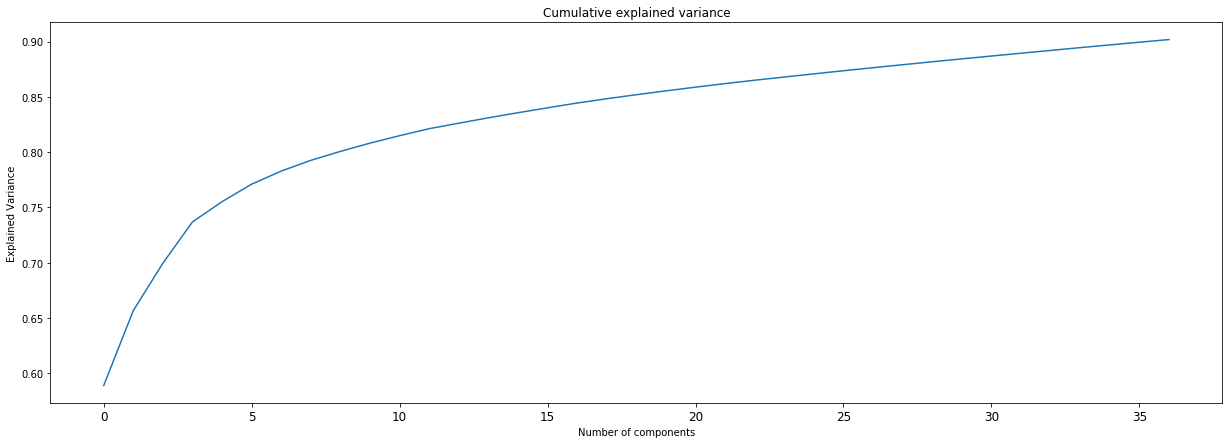

In [77]:
plt.subplots(figsize=(21,7))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.show()

#### KMeans

In [78]:
# Choose an optimal # of clusters
# With help of "How to determine the optimal number of clusters for k-means clustering"
# https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

sum_of_squared_distances = []
for k in range(2,20):
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(azdias_reduced)
    sum_of_squared_distances.append(kmeans.inertia_)

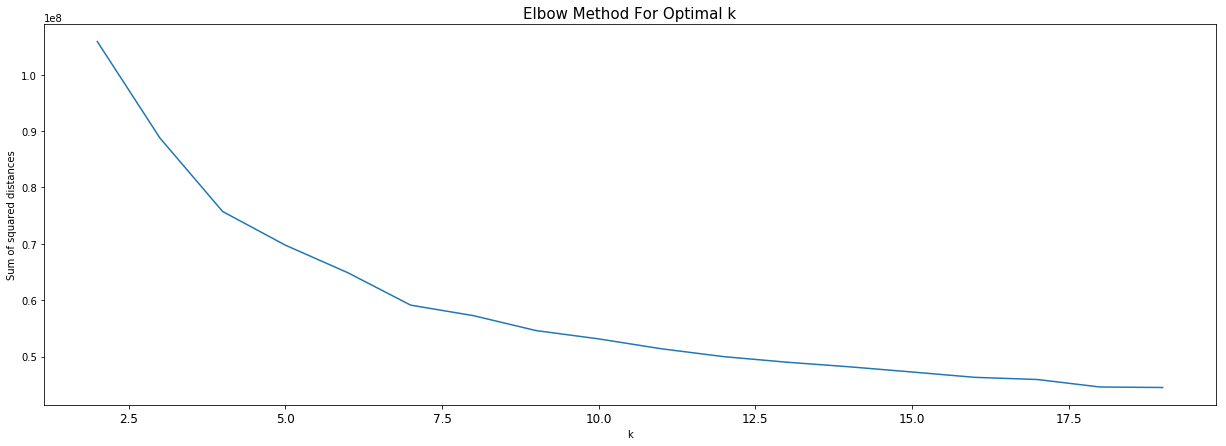

In [79]:
plt.subplots(figsize=(21,7))
plt.plot(range(2,20), sum_of_squared_distances)
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k', fontsize=15)
plt.show()

It's very difficult to determine the optimal # of clusters from this figure. So, in the further analysis of 2-10 clusters will be performed.

In [80]:
def kmeans(df, n_clusters):
    df = pd.DataFrame(df)

    kmeans = KMeans(n_clusters=n_clusters).fit(df)
                
    cluster_map = pd.DataFrame()
    cluster_map['cluster'] = kmeans.labels_

    return kmeans, cluster_map

#### k=10

In [81]:
kmeans_azdias, cluster_map = kmeans(azdias_reduced, 10)

In [82]:
preds_azdias = pd.DataFrame(kmeans_azdias.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers = pd.DataFrame(kmeans_azdias.predict(customers_reduced), columns=['CUSTOMERS'])

preds = pd.concat([preds_azdias['AZDIAS'].value_counts(), preds_customers['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds

,AZDIAS,CUSTOMERS
0,34090,1.0
1,103054,NaN
2,74893,50753.0
3,171095,NaN
4,145983,NaN
5,78740,91928.0
6,6566,528.0
7,130548,48442.0
8,121911,NaN
9,24341,NaN


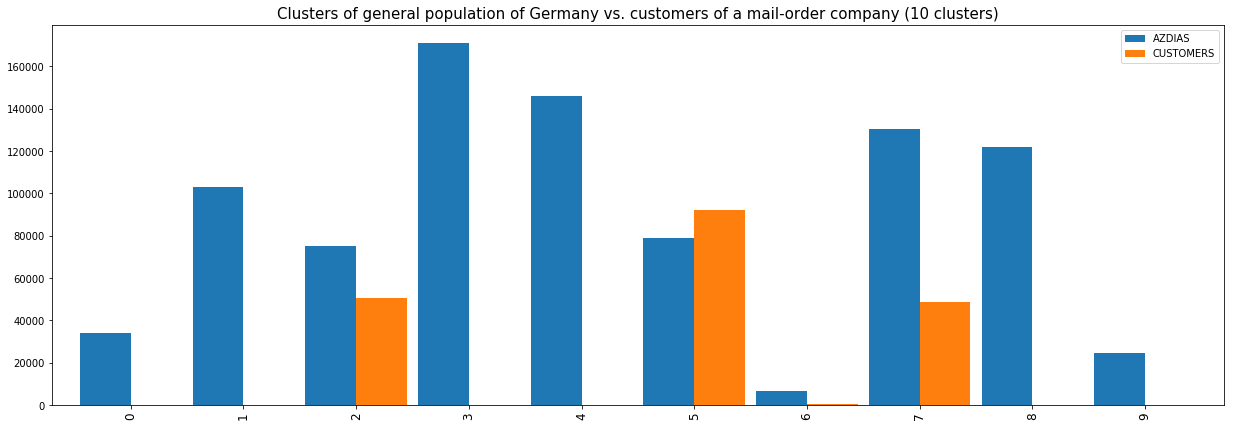

In [83]:
preds.plot(kind='bar', figsize=(21,7), width=.9)
plt.title('Clusters of general population of Germany vs. customers of a mail-order company (10 clusters)', fontsize=15)
plt.legend()
plt.show()

#### k=9

In [84]:
kmeans_azdias, cluster_map = kmeans(azdias_reduced, 9)

In [85]:
preds_azdias = pd.DataFrame(kmeans_azdias.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers = pd.DataFrame(kmeans_azdias.predict(customers_reduced), columns=['CUSTOMERS'])

preds = pd.concat([preds_azdias['AZDIAS'].value_counts(), preds_customers['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds

,AZDIAS,CUSTOMERS
0,171094,NaN
1,24341,NaN
2,136907,NaN
3,118779,NaN
4,74893,50753.0
5,34090,NaN
6,138280,140371.0
7,186271,NaN
8,6566,528.0


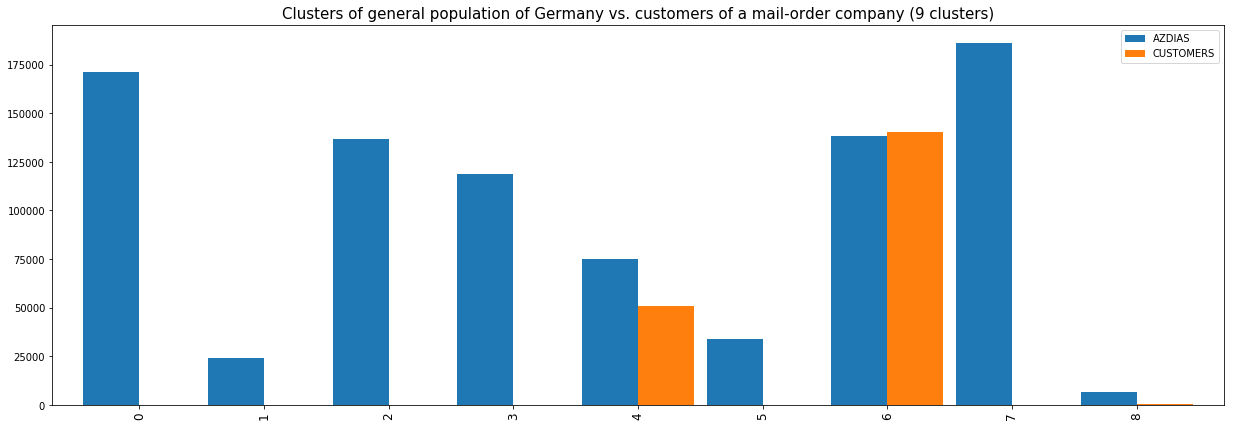

In [86]:
preds.plot(kind='bar', figsize=(21,7), width=.9)
plt.title('Clusters of general population of Germany vs. customers of a mail-order company (9 clusters)', fontsize=15)
plt.legend()
plt.show()

#### k=8

In [87]:
kmeans_azdias, cluster_map = kmeans(azdias_reduced, 8)

In [88]:
preds_azdias = pd.DataFrame(kmeans_azdias.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers = pd.DataFrame(kmeans_azdias.predict(customers_reduced), columns=['CUSTOMERS'])

preds = pd.concat([preds_azdias['AZDIAS'].value_counts(), preds_customers['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds

,AZDIAS,CUSTOMERS
0,212283,12605.0
1,74893,50753.0
2,189846,NaN
3,177307,127692.0
4,34090,74.0
5,24341,NaN
6,6566,528.0
7,171895,NaN


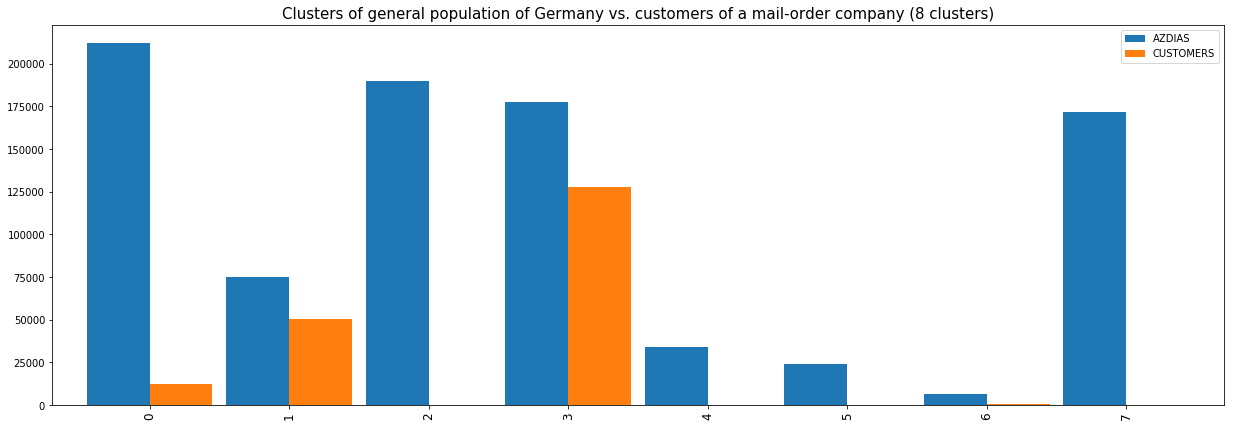

In [89]:
preds.plot(kind='bar', figsize=(21,7), width=.9)
plt.title('Clusters of general population of Germany vs. customers of a mail-order company (8 clusters)', fontsize=15)
plt.legend()
plt.show()

#### k=7

In [90]:
kmeans_azdias, cluster_map = kmeans(azdias_reduced, 7)

In [91]:
preds_azdias = pd.DataFrame(kmeans_azdias.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers = pd.DataFrame(kmeans_azdias.predict(customers_reduced), columns=['CUSTOMERS'])

preds = pd.concat([preds_azdias['AZDIAS'].value_counts(), preds_customers['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds

,AZDIAS,CUSTOMERS
0,212598,12560.0
1,93153,51281.0
2,189985,NaN
3,176845,127738.0
4,34090,73.0
5,12647,NaN
6,171903,NaN


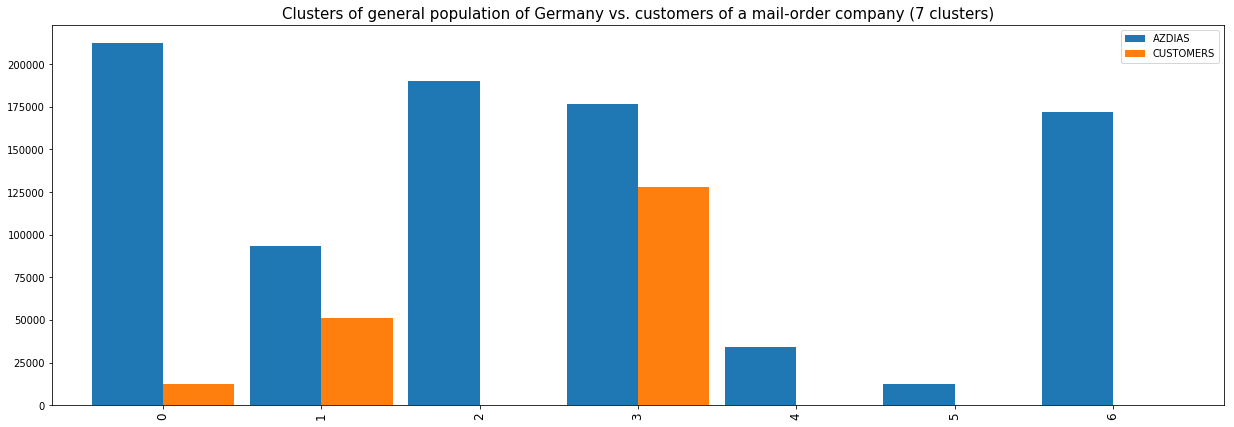

In [92]:
preds.plot(kind='bar', figsize=(21,7), width=.9)
plt.title('Clusters of general population of Germany vs. customers of a mail-order company (7 clusters)', fontsize=15)
plt.legend()
plt.show()

#### k=6

In [93]:
kmeans_azdias, cluster_map = kmeans(azdias_reduced, 6)

In [94]:
preds_azdias = pd.DataFrame(kmeans_azdias.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers = pd.DataFrame(kmeans_azdias.predict(customers_reduced), columns=['CUSTOMERS'])

preds = pd.concat([preds_azdias['AZDIAS'].value_counts(), preds_customers['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds

,AZDIAS,CUSTOMERS
0,273671,112508
1,99234,50753
2,34090,5227
3,171105,1918
4,6566,528
5,306555,20718


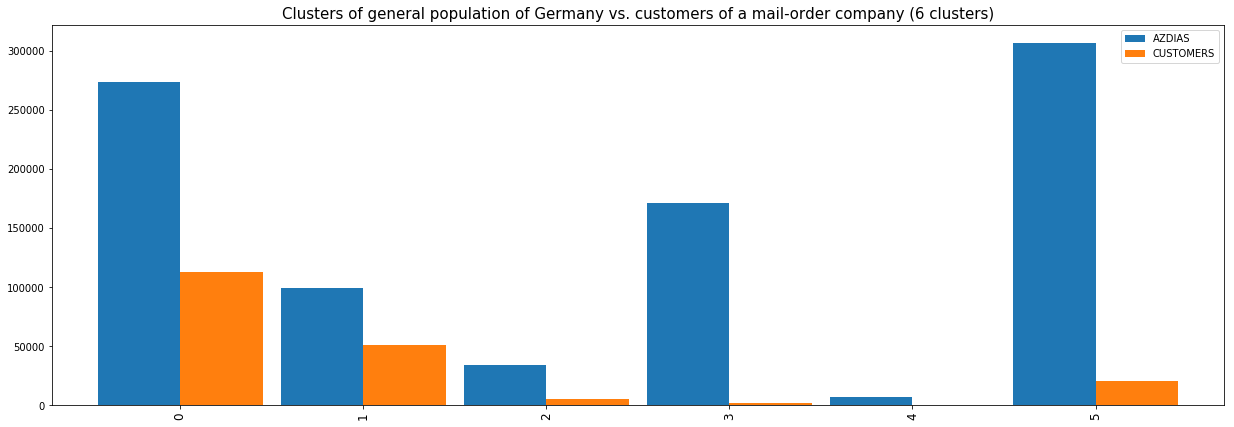

In [95]:
preds.plot(kind='bar', figsize=(21,7), width=.9)
plt.title('Clusters of general population of Germany vs. customers of a mail-order company (6 clusters)', fontsize=15)
plt.legend()
plt.show()

#### k=5

In [96]:
kmeans_azdias, cluster_map = kmeans(azdias_reduced, 5)

In [97]:
preds_azdias = pd.DataFrame(kmeans_azdias.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers = pd.DataFrame(kmeans_azdias.predict(customers_reduced), columns=['CUSTOMERS'])

preds = pd.concat([preds_azdias['AZDIAS'].value_counts(), preds_customers['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds

,AZDIAS,CUSTOMERS
0,230007,NaN
1,105800,51281.0
2,256113,138184.0
3,34090,2187.0
4,265211,NaN


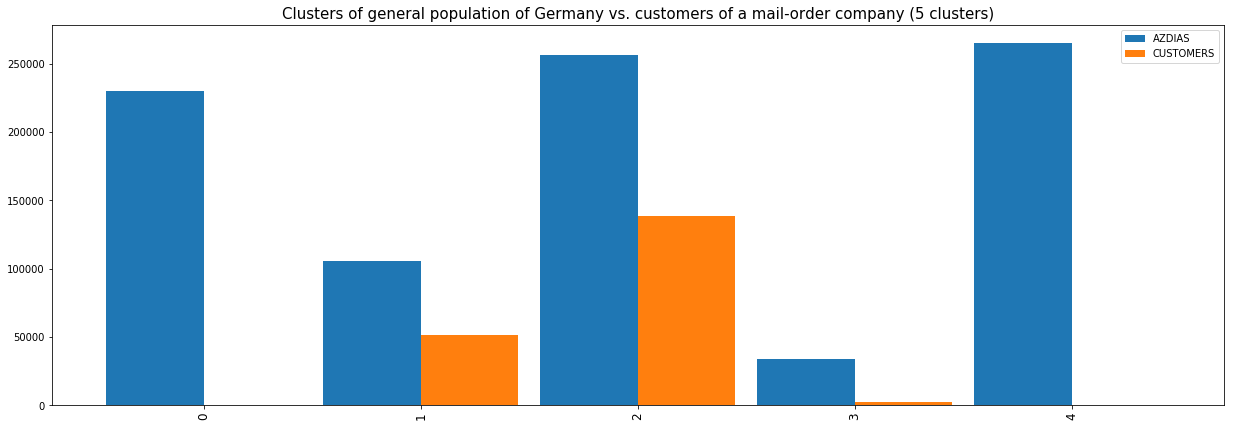

In [98]:
preds.plot(kind='bar', figsize=(21,7), width=.9)
plt.title('Clusters of general population of Germany vs. customers of a mail-order company (5 clusters)', fontsize=15)
plt.legend()
plt.show()

#### k=4

In [99]:
kmeans_azdias, cluster_map = kmeans(azdias_reduced, 4)

In [100]:
preds_azdias = pd.DataFrame(kmeans_azdias.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers = pd.DataFrame(kmeans_azdias.predict(customers_reduced), columns=['CUSTOMERS'])

preds = pd.concat([preds_azdias['AZDIAS'].value_counts(), preds_customers['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds

,AZDIAS,CUSTOMERS
0,386994,113128
1,34090,5227
2,364337,22016
3,105800,51281


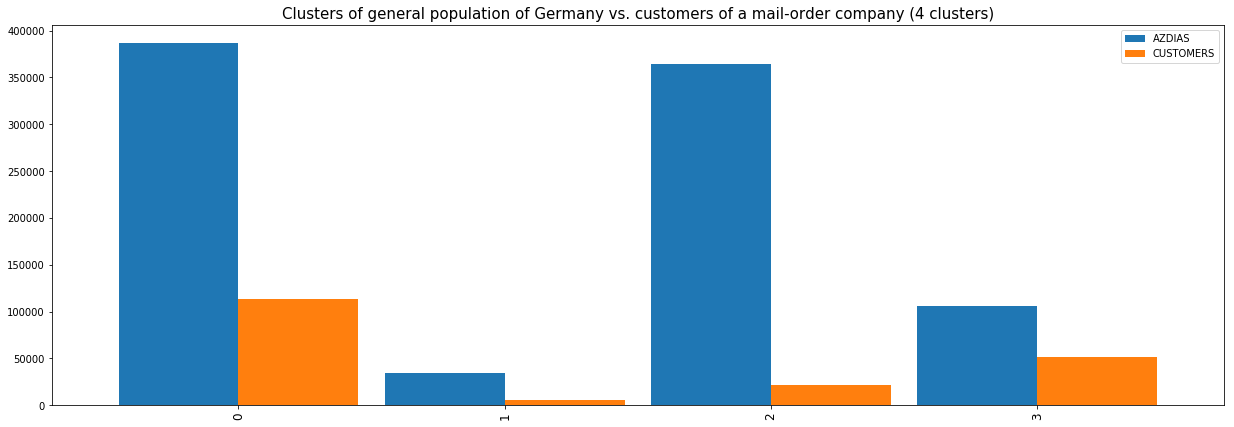

In [101]:
preds.plot(kind='bar', figsize=(21,7), width=.9)
plt.title('Clusters of general population of Germany vs. customers of a mail-order company (4 clusters)', fontsize=15)
plt.legend()
plt.show()

#### k=3

In [102]:
kmeans_azdias, cluster_map = kmeans(azdias_reduced, 3)

In [103]:
preds_azdias = pd.DataFrame(kmeans_azdias.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers = pd.DataFrame(kmeans_azdias.predict(customers_reduced), columns=['CUSTOMERS'])

preds = pd.concat([preds_azdias['AZDIAS'].value_counts(), preds_customers['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds

,AZDIAS,CUSTOMERS
0,751331,135144
1,105800,51281
2,34090,5227


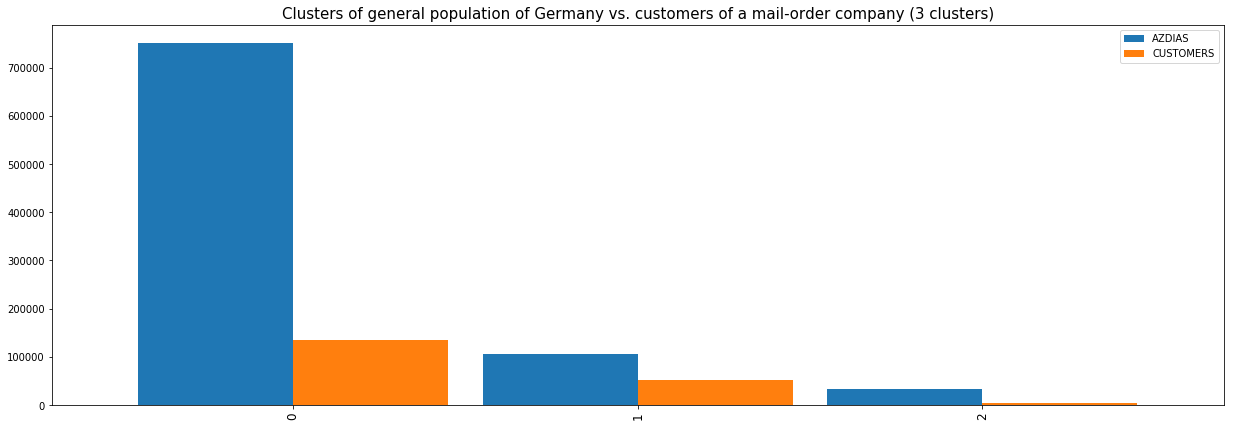

In [104]:
preds.plot(kind='bar', figsize=(21,7), width=.9)
plt.title('Clusters of general population of Germany vs. customers of a mail-order company (3 clusters)', fontsize=15)
plt.legend()
plt.show()

#### k=2

In [105]:
kmeans_azdias, cluster_map = kmeans(azdias_reduced, 2)

In [106]:
preds_azdias = pd.DataFrame(kmeans_azdias.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers = pd.DataFrame(kmeans_azdias.predict(customers_reduced), columns=['CUSTOMERS'])

preds = pd.concat([preds_azdias['AZDIAS'].value_counts(), preds_customers['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds

,AZDIAS,CUSTOMERS
0,785421,140371
1,105800,51281


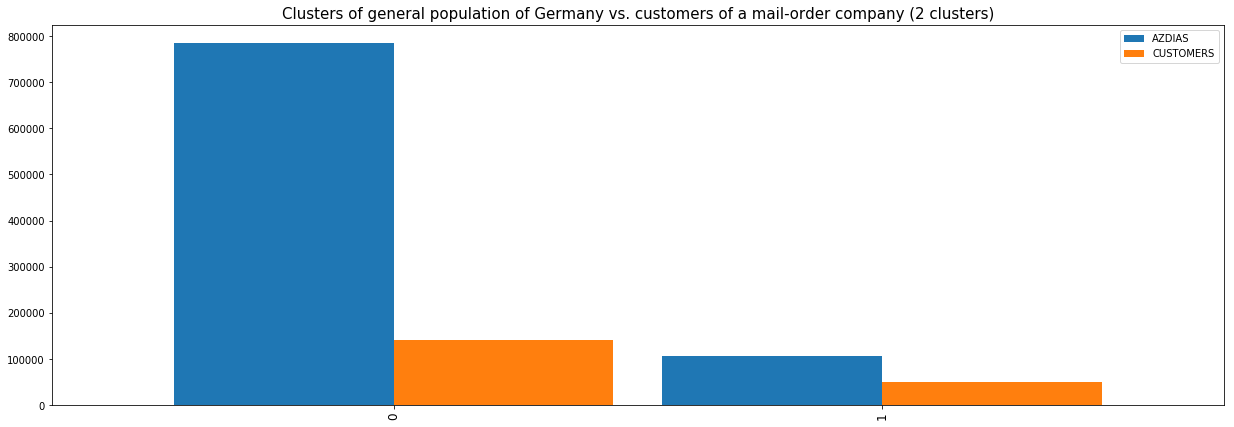

In [107]:
preds.plot(kind='bar', figsize=(21,7), width=.9)
plt.title('Clusters of general population of Germany vs. customers of a mail-order company (2 clusters)', fontsize=15)
plt.legend()
plt.show()

#### Discuss results

For the prepared demographic data of the general population of Germany and customers, the use of more than 4 clusters leads to the fact that a disproportion appears in the results, and some of the people from the customers simply do not fall into the corresponding clusters of the entire population.

On the one hand, we are losing some of the information, reducing the number of clusters, on the other hand, hoping that customers will be exactly like the general population of Germany is only one of the possible options for segmentation of demographic data.

For further analysis, it is necessary to choose the most acceptable 1-2 types of clustering, and on their basis try to implement certain marketing strategies. Thus, significantly reducing costs and not covering all customers. And of course, further research needs to look at the results of hierarchical clustering in order to compare several clustering methods. This analysis will take more resources, including time, than KMeans clustering

In [108]:
kmeans_azdias_4, cluster_map_4 = kmeans(azdias_reduced, 4)

preds_azdias_4 = pd.DataFrame(kmeans_azdias_4.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers_4 = pd.DataFrame(kmeans_azdias_4.predict(customers_reduced), columns=['CUSTOMERS'])

preds_4 = pd.concat([preds_azdias_4['AZDIAS'].value_counts(), preds_customers_4['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds_4

,AZDIAS,CUSTOMERS
0,362017,22227
1,105800,51281
2,34090,5227
3,389314,112917


In [109]:
preds_4['AZDIAS'] = round(preds_4['AZDIAS'] / preds_4['AZDIAS'].sum() * 100, 1)
preds_4['CUSTOMERS'] = round(preds_4['CUSTOMERS'] / preds_4['CUSTOMERS'].sum() * 100, 1)
preds_4

,AZDIAS,CUSTOMERS
0,40.6,11.6
1,11.9,26.8
2,3.8,2.7
3,43.7,58.9


In [110]:
preds_azdias_4.shape, preds_customers_4.shape

((891221, 1), (191652, 1))

In [111]:
kmeans_azdias_3, cluster_map_3 = kmeans(azdias_reduced, 3)

preds_azdias_3 = pd.DataFrame(kmeans_azdias_3.predict(azdias_reduced), columns=['AZDIAS'])
preds_customers_3 = pd.DataFrame(kmeans_azdias_3.predict(customers_reduced), columns=['CUSTOMERS'])

preds_3 = pd.concat([preds_azdias_3['AZDIAS'].value_counts(), preds_customers_3['CUSTOMERS'].value_counts()],
                                                     axis=1, sort=False)

preds_3

,AZDIAS,CUSTOMERS
1,751331,135144
0,105800,51281
2,34090,5227


In [112]:
preds_3['AZDIAS'] = round(preds_3['AZDIAS'] / preds_3['AZDIAS'].sum() * 100, 1)
preds_3['CUSTOMERS'] = round(preds_3['CUSTOMERS'] / preds_3['CUSTOMERS'].sum() * 100, 1)
preds_3

,AZDIAS,CUSTOMERS
1,84.3,70.5
0,11.9,26.8
2,3.8,2.7


In [113]:
preds_azdias_3.shape, preds_customers_3.shape

((891221, 1), (191652, 1))

In [114]:
'Shape extra customers DF' + str(customers_extra.shape)

'Shape extra customers DF(191652, 3)'

#### Analyze 4 clusters scenario

In [223]:
preds_customers_4 = pd.concat([preds_customers_4, customers_extra], axis=1, sort=False)
print('Shape (4 clusters)', preds_customers_4.shape)
preds_customers_4.head()

Shape (4 clusters) (191652, 4)


,CUSTOMERS,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,2,MULTI_BUYER,No,COSMETIC_AND_FOOD
1,1,SINGLE_BUYER,No,FOOD
2,0,MULTI_BUYER,No,COSMETIC_AND_FOOD
3,2,MULTI_BUYER,No,COSMETIC
4,2,MULTI_BUYER,No,FOOD


In [224]:
round(pd.crosstab(preds_customers_4['CUSTOMERS'], preds_customers_4['CUSTOMER_GROUP'])
      / preds_customers_4.shape[0] * 100, 1)

CUSTOMER_GROUP,MULTI_BUYER,SINGLE_BUYER
CUSTOMERS,,
0,9.5,2.8
1,17.6,9.2
2,40.1,18.0
3,1.8,1.0


In [225]:
round(pd.crosstab(preds_customers_4['CUSTOMERS'], preds_customers_4['ONLINE_PURCHASE'])
      / preds_customers_4.shape[0] * 100, 1)

ONLINE_PURCHASE,No,Yes
CUSTOMERS,,
0,12.0,0.4
1,24.1,2.7
2,52.7,5.5
3,2.2,0.5


In [226]:
round(pd.crosstab(preds_customers_4['CUSTOMERS'], preds_customers_4['PRODUCT_GROUP'])
      / preds_customers_4.shape[0] * 100, 1)

PRODUCT_GROUP,COSMETIC,COSMETIC_AND_FOOD,FOOD
CUSTOMERS,,,
0,2.3,7.6,2.5
1,6.4,13.2,7.1
2,13.3,30.5,14.4
3,0.6,1.3,0.8


In [227]:
preds_customers_4['ONLINE_PURCHASE'] = preds_customers_4['ONLINE_PURCHASE'].replace({'Yes': 1, 'No': 0})
round(pd.pivot_table(data=preds_customers_4, index='CUSTOMERS', columns='CUSTOMER_GROUP', values='ONLINE_PURCHASE',
               aggfunc='mean') * 100, 1)

CUSTOMER_GROUP,MULTI_BUYER,SINGLE_BUYER
CUSTOMERS,,
0,2.5,4.6
1,8.9,12.3
2,9.2,9.8
3,17.4,19.3


In [229]:
round(pd.pivot_table(data=preds_customers_4, index='CUSTOMERS', columns='PRODUCT_GROUP', values='ONLINE_PURCHASE',
               aggfunc='mean') * 100, 1)

PRODUCT_GROUP,COSMETIC,COSMETIC_AND_FOOD,FOOD
CUSTOMERS,,,
0,5.3,2.3,3.1
1,16.2,7.9,8.7
2,10.9,8.9,9.2
3,23.9,16.6,15.9


#### Analyze 3 clusters scenario

In [230]:
preds_customers_3 = pd.concat([preds_customers_3, customers_extra], axis=1, sort=False)
print('Shape (3 clusters)', preds_customers_3.shape)
preds_customers_3.head()

Shape (3 clusters) (191652, 4)


,CUSTOMERS,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,0,MULTI_BUYER,No,COSMETIC_AND_FOOD
1,1,SINGLE_BUYER,No,FOOD
2,0,MULTI_BUYER,No,COSMETIC_AND_FOOD
3,0,MULTI_BUYER,No,COSMETIC
4,0,MULTI_BUYER,No,FOOD


In [231]:
round(pd.crosstab(preds_customers_3['CUSTOMERS'], preds_customers_3['CUSTOMER_GROUP'])
      / preds_customers_3.shape[0] * 100, 1)

CUSTOMER_GROUP,MULTI_BUYER,SINGLE_BUYER
CUSTOMERS,,
0,49.7,20.8
1,17.6,9.2
2,1.8,1.0


In [232]:
round(pd.crosstab(preds_customers_3['CUSTOMERS'], preds_customers_3['ONLINE_PURCHASE'])
      / preds_customers_3.shape[0] * 100, 1)

ONLINE_PURCHASE,No,Yes
CUSTOMERS,,
0,64.7,5.8
1,24.1,2.7
2,2.2,0.5


In [233]:
round(pd.crosstab(preds_customers_3['CUSTOMERS'], preds_customers_3['PRODUCT_GROUP'])
      / preds_customers_3.shape[0] * 100, 1)

PRODUCT_GROUP,COSMETIC,COSMETIC_AND_FOOD,FOOD
CUSTOMERS,,,
0,15.6,38.1,16.8
1,6.4,13.2,7.1
2,0.6,1.3,0.8


In [234]:
preds_customers_3['ONLINE_PURCHASE'] = preds_customers_3['ONLINE_PURCHASE'].replace({'Yes': 1, 'No': 0})
round(pd.pivot_table(data=preds_customers_3, index='CUSTOMERS', columns='CUSTOMER_GROUP', values='ONLINE_PURCHASE',
               aggfunc='mean') * 100, 1)

CUSTOMER_GROUP,MULTI_BUYER,SINGLE_BUYER
CUSTOMERS,,
0,7.9,9.1
1,8.9,12.3
2,17.4,19.3


In [235]:
round(pd.pivot_table(data=preds_customers_3, index='CUSTOMERS', columns='PRODUCT_GROUP', values='ONLINE_PURCHASE',
               aggfunc='mean') * 100, 1)

PRODUCT_GROUP,COSMETIC,COSMETIC_AND_FOOD,FOOD
CUSTOMERS,,,
0,10.0,7.5,8.3
1,16.2,7.9,8.7
2,23.9,16.6,15.9


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [116]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [117]:
'Shape', mailout_train.shape

('Shape', (42962, 367))

In [134]:
y = mailout_train['RESPONSE']
X = mailout_train.drop('RESPONSE', axis=1)
X = clean_demographic_data(X, unknown)

Whether all values in LNR column are unique in azdias DF - True
Final check of missing values 0


In [135]:
'Shape X', X.shape

('Shape X', (42962, 354))

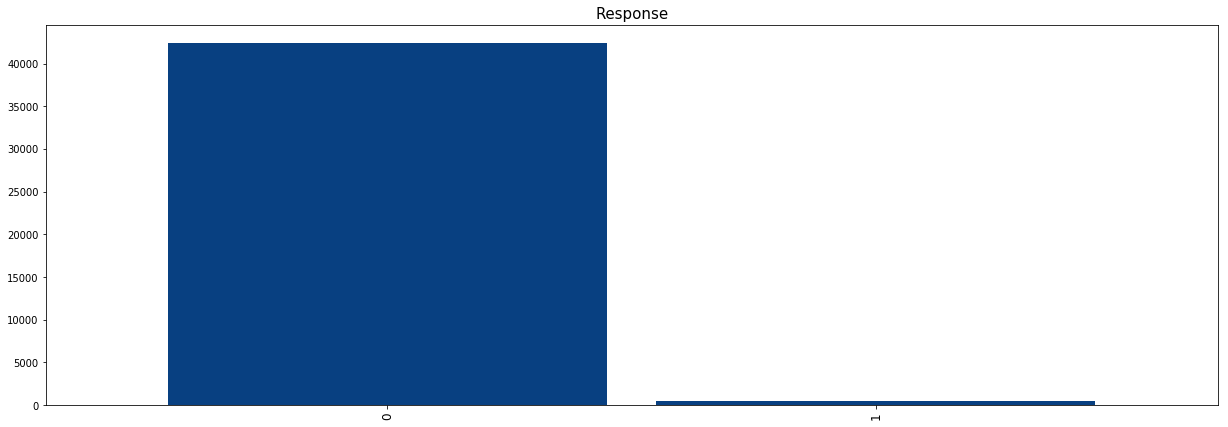

In [136]:
plt.rc('xtick', labelsize=12)

plt.subplots(figsize=(21,7))
y.value_counts().iloc[:20].plot(kind='bar', width=0.9, cmap='GnBu_r')
plt.title('Response', fontsize=15)
plt.show()

In [137]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [147]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32221, 354), (10741, 354), (32221,), (10741,))

In [138]:
pipeline = Pipeline([
        ('scale', scaler),
        ('clf', RandomForestClassifier(class_weight='balanced'))
    ])

In [139]:
# Train pipeline
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [160]:
pred = pipeline.predict(X_test)
print(pred.shape, y_test.shape)

precision_ = precision_score(y_test, pred)
recall_ = recall_score(y_test, pred)
f1_ = f1_score(y_test, pred)
accuracy_ = accuracy_score(y_test, pred)

precision_, recall_, f1_, accuracy_

(10741,) (10741,)


(0.0096618357487922701, 0.03125, 0.014760147601476014, 0.95028395866306681)

In [161]:
y_train.mean(), y_test.mean(), pred.mean()

(0.01253840662921697, 0.011916953728703101, 0.038543897216274089)

In [162]:
# Use grid search to find better parameters

parameters = {
        'clf__n_estimators': [10, 20]
    }

cv = GridSearchCV(pipeline, param_grid=parameters)

In [163]:
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__n_estimators': [10, 20]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [164]:
pred_2 = cv.predict(X_test)
print(pred_2.shape, y_test.shape)

precision_ = precision_score(y_test, pred_2)
recall_ = recall_score(y_test, pred_2)
f1_ = f1_score(y_test, pred_2)
accuracy_ = accuracy_score(y_test, pred_2)

precision_, recall_, f1_, accuracy_

(10741,) (10741,)


(0.0096618357487922701, 0.03125, 0.014760147601476014, 0.95028395866306681)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [165]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [166]:
mailout_test.shape

(42833, 366)

In [167]:
lnr = mailout_test['LNR']
mailout_test_cleaned = clean_demographic_data(mailout_test, unknown)

Whether all values in LNR column are unique in azdias DF - True
Final check of missing values 0


In [168]:
pred_3 = pipeline.predict(mailout_test_cleaned)
pred_4 = cv.predict(mailout_test_cleaned)

In [171]:
arvato_capstone_submission_3 = pd.DataFrame({'LNR': lnr, 'RESPONSE': pred_3})
arvato_capstone_submission_4 = pd.DataFrame({'LNR': lnr, 'RESPONSE': pred_4})

In [172]:
arvato_capstone_submission_3.to_csv('Arvato_Capstone_Submission_3.csv', index=False)
arvato_capstone_submission_4.to_csv('Arvato_Capstone_Submission_4.csv', index=False)